In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
import itertools
from itertools import combinations
import statsmodels.api as sm
import joblib
import os
import matplotlib.patches as mpatches

df = pd.read_csv("../data/clean_flu_data.csv", parse_dates=['date_clean'], index_col='date_clean')

In [5]:
features = [
    'tavg', 'tavg_slope', 'prcp_sum', 'vax_rate',
    'flu_cases_lag_7', 'flu_cases_lag_14', 'flu_cases_lag_21',
    'Tamiflu', 'fever', 'Cough', 'flu symptoms', 'sore throat',
    'in_season'
]

df['month'] = df.index.strftime('%b')
df = df[1:]

### Evaluation Method ###

In [6]:
def eval_seasonal(model, df, features, target='y', show_summary=True):
    seasons = sorted(df['season_year'].unique())
    rows = []
    importances = []
    preds_dict = {}

    for yr in seasons[1:]:
        train = df[df['season_year'] < yr]
        test = df[df['season_year'] == yr]

        X_train, y_train = train[features], train[target]
        X_test, y_test = test[features], test[target]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred = np.clip(y_pred, a_min=0, a_max=None)

        if target == 'y_log':
            y_pred = np.expm1(y_pred)
            y_test = np.expm1(y_test)

        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        total_cases = y_test.sum()
        rel_rmse = rmse / total_cases if total_cases else np.nan

        rows.append({
            'season': yr,
            'total_cases': int(total_cases),
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'RMSE % of total': rel_rmse * 100
        })

        preds_dict[yr] = pd.DataFrame({
            'y_true': y_test.values,
            'y_pred': y_pred,
            'index': test.index,
            'month': test['month'].values
        })

        # Collect importance
        if hasattr(model, 'coef_'):
            importances.append(np.abs(model.coef_))
        elif hasattr(model, 'feature_importances_'):
            importances.append(model.feature_importances_)

    perf_df = pd.DataFrame(rows)

    if show_summary:
        # Print average and weighted performance summary
        print(f"\n{model.__class__.__name__} performance summary:")
        mean_rmse = perf_df['RMSE'].mean()
        mean_mae = perf_df['MAE'].mean()
        mean_r2 = perf_df['R2'].mean()
        w_rmse = np.average(perf_df['RMSE'], weights=perf_df['total_cases'])
        w_mae = np.average(perf_df['MAE'], weights=perf_df['total_cases'])

        print(f"  Unweighted Mean RMSE: {mean_rmse:.2f}")
        print(f"  Unweighted Mean MAE : {mean_mae:.2f}")
        print(f"  Unweighted Mean R²  : {mean_r2:.3f}")
        print(f"  Weighted RMSE       : {w_rmse:.2f}")
        print(f"  Weighted MAE        : {w_mae:.2f}")

    if importances:
        mean_importance = np.mean(importances, axis=0)
        importance_df = pd.DataFrame({
            'feature': features,
            'importance': mean_importance
        }).sort_values('importance', ascending=False)
        return perf_df, importance_df, preds_dict

    return perf_df, None, preds_dict


This evaluation method will set each season, excluding the first, as the hold-out season. Each iteration will only use the season up to the target season to train on. So for an n-season dataset, there will be n-1 iterations and performance summaries. Weighted RMSE will be our main metric, as total cases per year vary. RMSE will also highlight any large errors, which is critical in epidemiological forecasting. We expect to see performance increase as season year increases, since more training data becomes available.

## Baseline Models

We will begin with simple Linear Regression (LR) and XGBoost (XGB) models, both commonly used in time series and epidemiology forecasting studies. LR provides a transparent baseline and is robust to overfitting, especially with small datasets. XGB, on the other hand, is well-suited for capturing non-linear relationships and interactions between features, which are common in disease spread. Both models are computationally efficient and widely validated, making them ideal starting points for benchmarking and further ensemble development.

In [7]:
lr = LinearRegression()
lr_perf, lr_importance, lr_preds = eval_seasonal(lr, df, features)
display(lr_perf, lr_importance)


LinearRegression performance summary:
  Unweighted Mean RMSE: 38.79
  Unweighted Mean MAE : 20.43
  Unweighted Mean R²  : 0.695
  Weighted RMSE       : 48.58
  Weighted MAE        : 25.26


,season,total_cases,RMSE,MAE,R2,RMSE % of total
0,2011,643,13.790756,7.279289,0.706163,2.144752
1,2012,1657,34.913439,15.357521,0.646208,2.107027
2,2013,1247,22.107536,12.189621,0.645270,1.772858
3,2014,2593,60.515592,26.552357,0.597411,2.333806
4,2015,1587,27.479753,18.205131,0.754757,1.731553
5,2016,2135,36.413502,21.182251,0.662036,1.705550
6,2017,5106,75.104582,36.696399,0.753865,1.470908
7,2018,3362,39.972107,25.968745,0.792380,1.188938


,feature,importance
3,vax_rate,51.557522
7,Tamiflu,15.167438
12,in_season,9.822860
10,flu symptoms,2.635236
11,sore throat,1.261835
1,tavg_slope,1.055647
9,Cough,0.865837
4,flu_cases_lag_7,0.853162
8,fever,0.432590
6,flu_cases_lag_21,0.419336


In [8]:
xgb = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, verbosity=0, random_state=13)
xgb_perf, xgb_importance, xgb_preds = eval_seasonal(xgb, df, features)
display(xgb_perf, xgb_importance)


XGBRegressor performance summary:
  Unweighted Mean RMSE: 51.09
  Unweighted Mean MAE : 24.45
  Unweighted Mean R²  : 0.441
  Weighted RMSE       : 67.56
  Weighted MAE        : 32.05


,season,total_cases,RMSE,MAE,R2,RMSE % of total
0,2011,643,30.203601,16.494561,-0.409443,4.697294
1,2012,1657,41.684656,18.921233,0.495670,2.515670
2,2013,1247,19.519368,9.341376,0.723466,1.565306
3,2014,2593,71.919587,28.841180,0.431380,2.773605
4,2015,1587,34.988547,17.472209,0.602421,2.204697
5,2016,2135,31.793682,17.035271,0.742352,1.489165
6,2017,5106,123.418974,57.767512,0.335333,2.417136
7,2018,3362,55.159005,29.755684,0.604644,1.640660


,feature,importance
4,flu_cases_lag_7,0.283052
9,Cough,0.267168
11,sore throat,0.164112
7,Tamiflu,0.085613
3,vax_rate,0.071647
6,flu_cases_lag_21,0.050231
10,flu symptoms,0.019860
5,flu_cases_lag_14,0.015587
8,fever,0.014954
2,prcp_sum,0.012309


I also trained each model using a log-transformed target variable (y), but this approach resulted in worse performance.

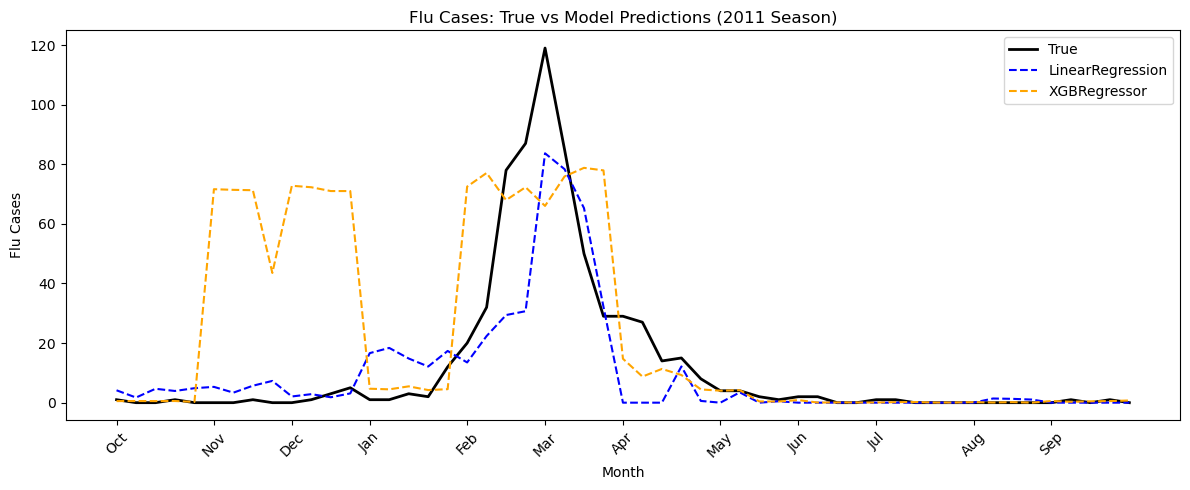

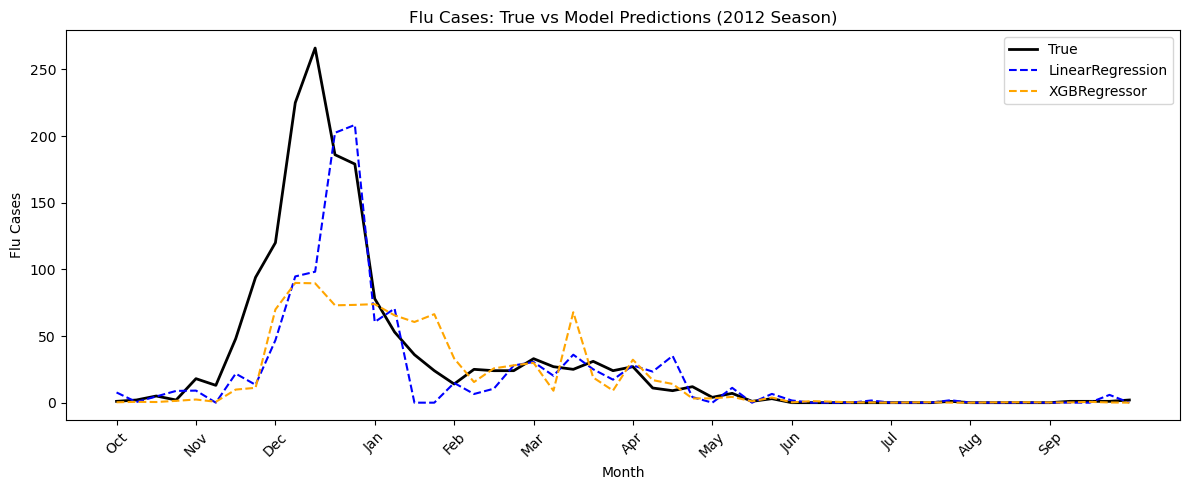

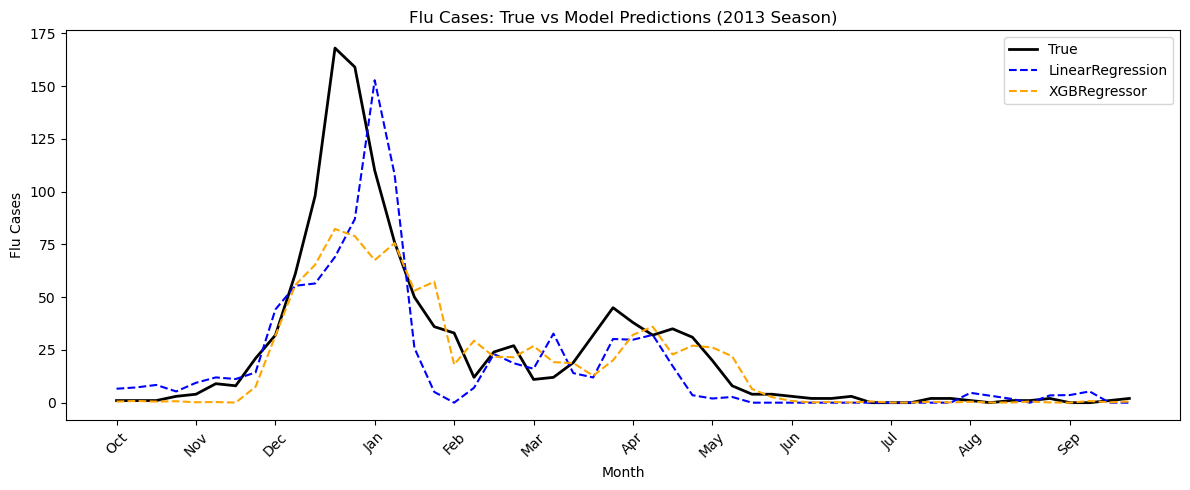

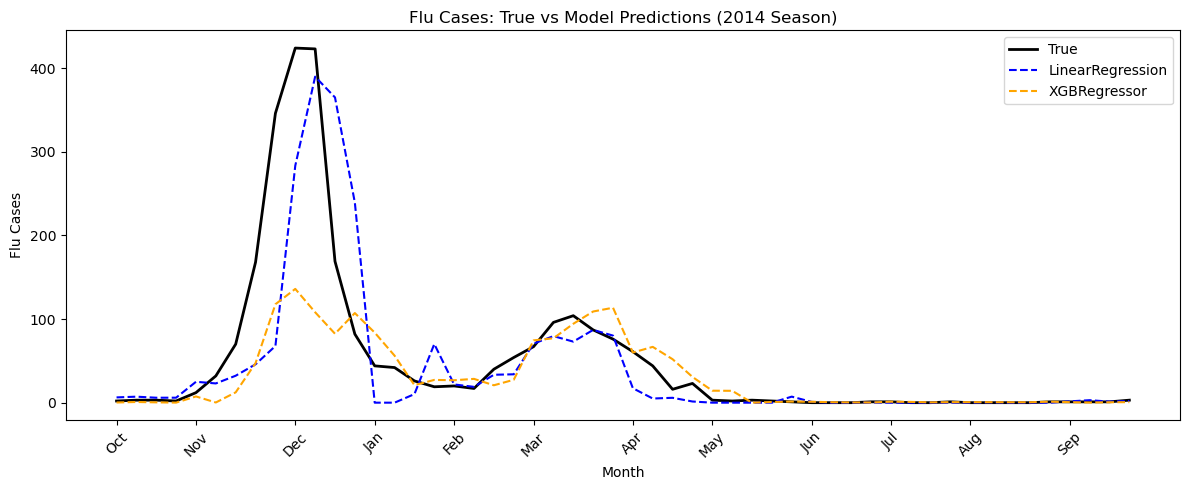

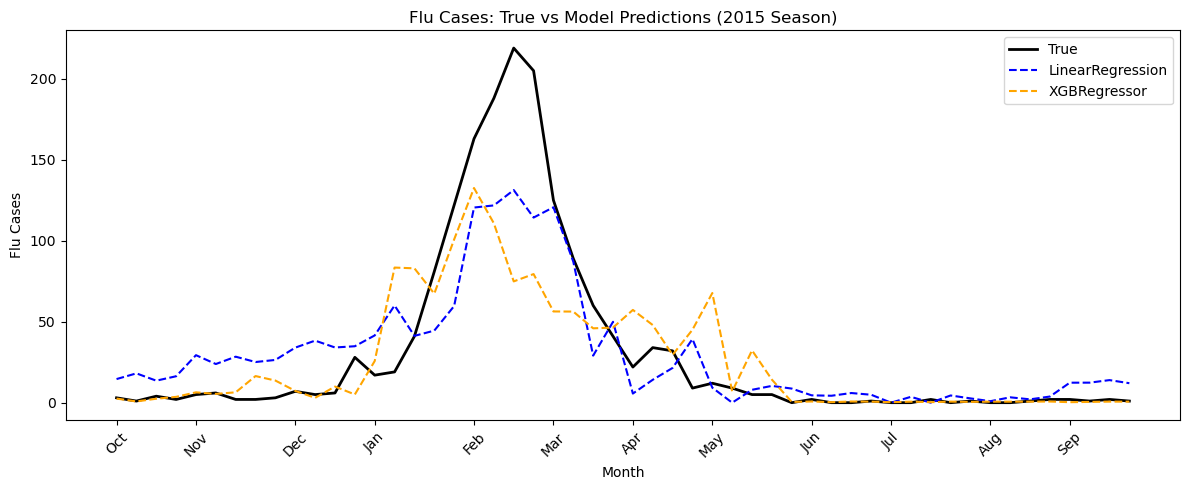

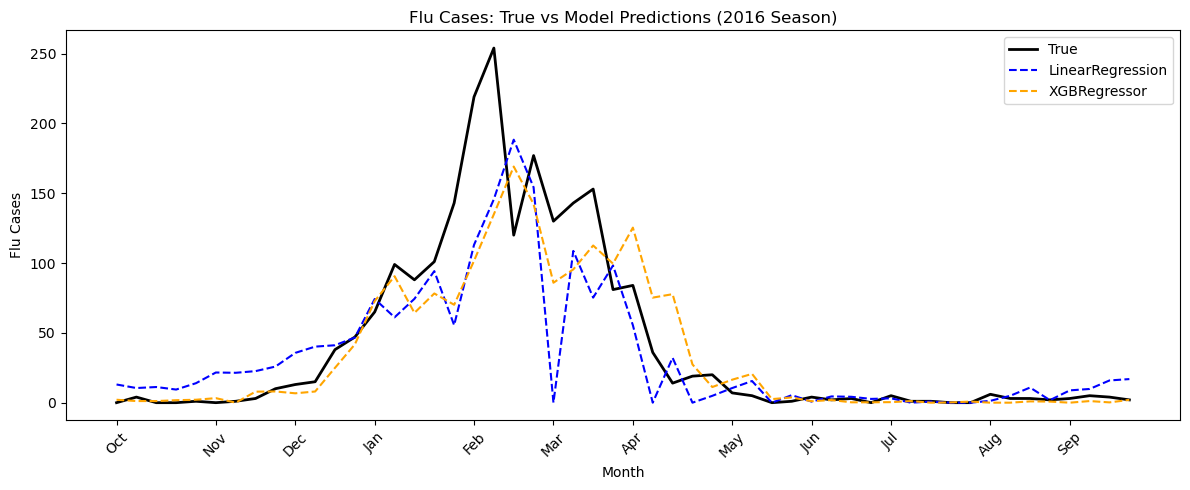

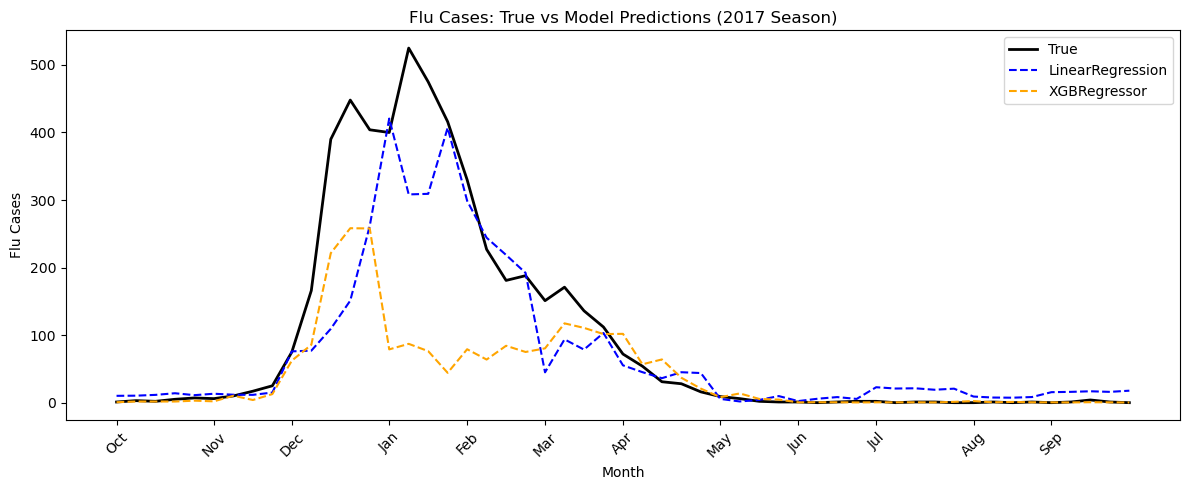

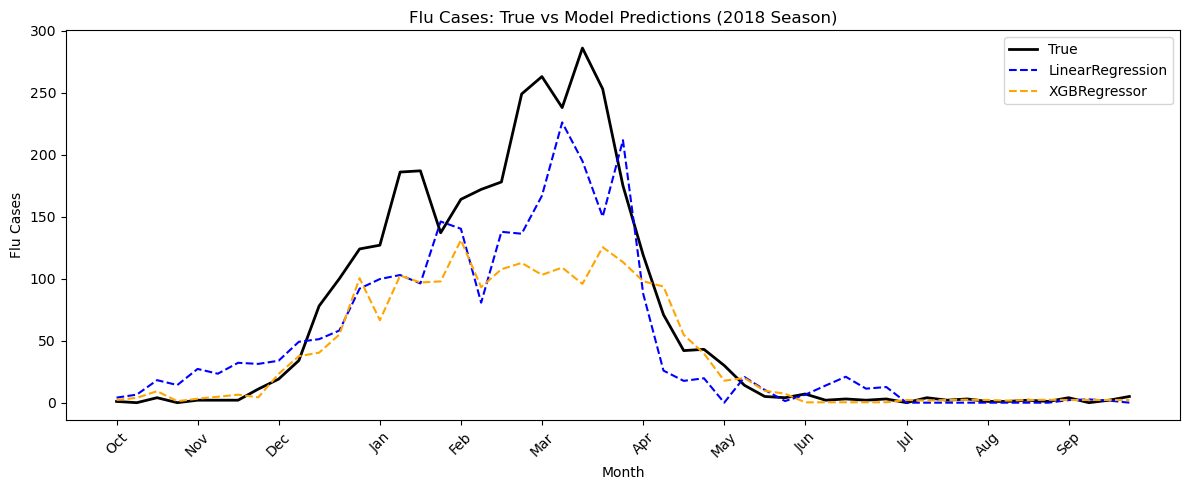

In [9]:
for yr in sorted(lr_preds.keys()):
    lr_season = lr_preds[yr]
    xgb_season = xgb_preds[yr]
    idx = lr_season['index']
    months = lr_season['month']
    y_true = lr_season['y_true']
    y_pred_lr = lr_season['y_pred']
    y_pred_xgb = xgb_season['y_pred']

    plt.figure(figsize=(12,5))
    plt.plot(idx, y_true, label='True', color='black', linewidth=2, linestyle='-')
    plt.plot(idx, y_pred_lr, label='LinearRegression', linestyle='--', color='blue')
    plt.plot(idx, y_pred_xgb, label='XGBRegressor', linestyle='--', color='orange')
    plt.title(f'Flu Cases: True vs Model Predictions ({yr} Season)')
    plt.xlabel('Month')
    plt.ylabel('Flu Cases')
    # Show each month name only once on the x-axis
    unique_months = []
    unique_locs = []
    for i, m in enumerate(months):
        if len(unique_months) == 0 or m != unique_months[-1]:
            unique_months.append(m)
            unique_locs.append(idx.iloc[i])
    plt.xticks(unique_locs, unique_months, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


Performance summaries for each model suggest that LR performs better (48.5 vs. 67.5 weighted RMSE, 25 vs. 32 weighted MAE) across most years. However, visual inspection reveals that XGB generally performs better in certain conditions. Specifically, during the early and late parts of most seasons, XGB fits the target variable more closely. This suggests that an ensemble, dynamically tuned based on the time of season, may outperform LR alone.

Before that we will clean up each individual model by removing any non-beneficial features.

Ablation Study: Remove each feature and evaluate impact on performance
----------------------------------------------------------------------

Feature importance ranking by weighted RMSE for LinearRegression:


,feature_removed,w_RMSE,w_MAE,w_R2,w_RMSE_pct
4,flu_cases_lag_7,56.615729,31.278976,0.610994,1.961160
7,Tamiflu,51.630306,25.545364,0.679329,1.774926
10,flu symptoms,49.356698,25.399287,0.700574,1.717346
5,flu_cases_lag_14,49.287030,25.850675,0.704588,1.708741
11,sore throat,48.811658,24.694593,0.708321,1.695402
2,prcp_sum,48.589470,25.223338,0.709474,1.692392
9,Cough,48.548364,24.983995,0.709842,1.691111
1,tavg_slope,48.519428,25.375208,0.711332,1.688280
6,flu_cases_lag_21,48.460893,24.978426,0.703577,1.709694
8,fever,48.412964,25.499325,0.710292,1.691417


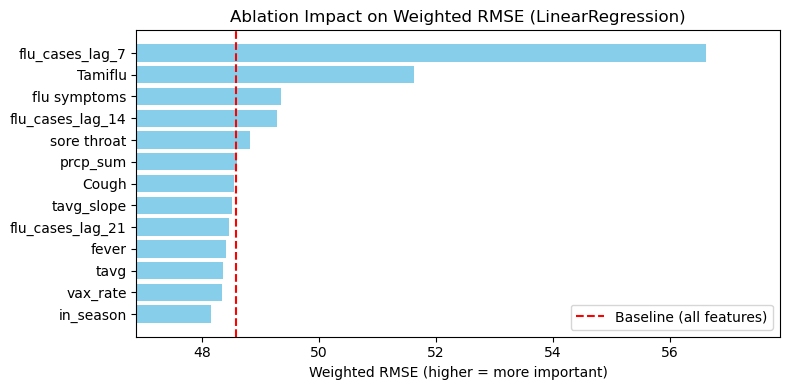


Feature importance ranking by weighted RMSE for XGBRegressor:


,feature_removed,w_RMSE,w_MAE,w_R2,w_RMSE_pct
17,flu_cases_lag_7,75.969969,37.295152,0.327832,2.550274
20,Tamiflu,69.128901,33.217648,0.462893,2.270932
16,vax_rate,67.852332,32.981042,0.468925,2.264952
19,flu_cases_lag_21,67.649306,32.730753,0.478731,2.253891
25,in_season,67.558577,32.050768,0.483621,2.229609
21,fever,67.478993,32.174198,0.486019,2.221858
14,tavg_slope,67.221163,31.798258,0.509778,2.175948
15,prcp_sum,67.087943,32.157124,0.489880,2.215306
18,flu_cases_lag_14,66.868300,31.933777,0.492617,2.209031
23,flu symptoms,66.669435,31.672501,0.492716,2.214295


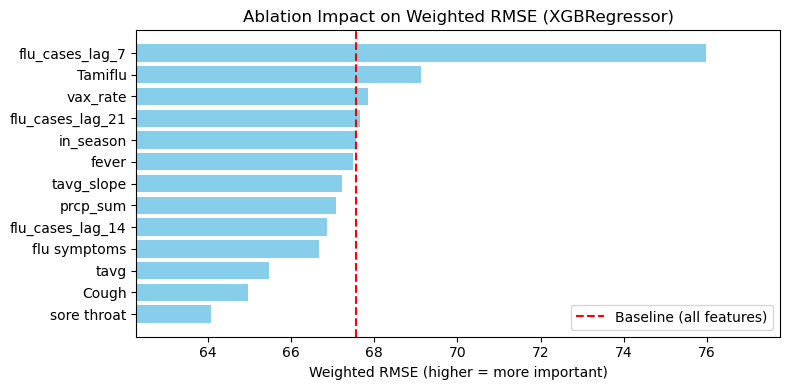

In [10]:
important_metrics = ['RMSE', 'MAE', 'R2', 'RMSE % of total']

print('Ablation Study: Remove each feature and evaluate impact on performance')
print('-' * 70)

base_features = features.copy()
abl_results = []
baseline_rmse = {}

for model_name, model in [('LinearRegression', LinearRegression()), ('XGBRegressor', XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, verbosity=0, random_state=13))]:
    # Baseline: all features
    perf_df, _, _ = eval_seasonal(deepcopy(model), df, base_features, target='y', show_summary=False)
    w_rmse_base = np.average(perf_df['RMSE'], weights=perf_df['total_cases'])
    baseline_rmse[model_name] = w_rmse_base
    for feat in base_features:
        ablated_feats = [f for f in base_features if f != feat]
        perf_df, _, _ = eval_seasonal(deepcopy(model), df, ablated_feats, target='y', show_summary=False)
        w_rmse = np.average(perf_df['RMSE'], weights=perf_df['total_cases'])
        w_mae = np.average(perf_df['MAE'], weights=perf_df['total_cases'])
        w_r2 = np.average(perf_df['R2'], weights=perf_df['total_cases'])
        w_rmse_pct = np.average(perf_df['RMSE % of total'], weights=perf_df['total_cases'])
        abl_results.append({'model': model_name, 'feature_removed': feat, 'w_RMSE': w_rmse, 'w_MAE': w_mae, 'w_R2': w_r2, 'w_RMSE_pct': w_rmse_pct})

abl_df = pd.DataFrame(abl_results)

for model_name in abl_df['model'].unique():
    print(f"\nFeature importance ranking by weighted RMSE for {model_name}:")
    model_df = abl_df[abl_df['model'] == model_name].sort_values('w_RMSE', ascending=False)
    display(model_df[['feature_removed', 'w_RMSE', 'w_MAE', 'w_R2', 'w_RMSE_pct']])

    plt.figure(figsize=(8,4))
    plt.barh(model_df['feature_removed'], model_df['w_RMSE'], color='skyblue')
    # Baseline RMSE line
    plt.axvline(baseline_rmse[model_name], color='red', linestyle='--', label='Baseline (all features)')
    # Zoom x-axis: just below min, just above max
    min_rmse = model_df['w_RMSE'].min()
    max_rmse = model_df['w_RMSE'].max()
    margin = (max_rmse - min_rmse) * 0.15 if max_rmse > min_rmse else 1
    plt.xlim(min_rmse - margin, max_rmse + margin)
    plt.xlabel('Weighted RMSE (higher = more important)')
    plt.title(f'Ablation Impact on Weighted RMSE ({model_name})')
    plt.legend()
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

The ablation impacts exposed multiple detrimental features. For Google Trends data, this is likely due to high correlation. For two- and three-week case lags, we can conclude that the data is too old to have any noticeable impact on future cases (at least for these models). For temperature, it likely does not have a strong enough relationship to influenza spread.

Since dropping one feature may lessen or even reverse the negative impact of another, we will try all combinations of features whose ablation impacts were positive.

In [11]:
base_features_lr = features.copy()
base_features_xgb = features.copy()

drop_lr = ['in_season', 'tavg', 'fever', 'flu_cases_lag_21', 'vax_rate']
drop_xgb = ['sore throat', 'tavg', 'Cough', 'flu_cases_lag_14', 'flu symptoms', 'prcp_sum', 'tavg_slope']

def find_best_features(model_class, base_features, drop_candidates):
    best_rmse = float('inf')
    best_feats = base_features.copy()
    best_drop = []
    # Try all combinations of dropping 1 to all drop candidates
    for r in range(len(drop_candidates)+1):
        for drop_set in combinations(drop_candidates, r):
            feats = [f for f in base_features if f not in drop_set]
            model = model_class()
            perf_df, _, _ = eval_seasonal(model, df, feats, target='y', show_summary=False)
            w_rmse = np.average(perf_df['RMSE'], weights=perf_df['total_cases'])
            if w_rmse < best_rmse:
                best_rmse = w_rmse
                best_feats = feats.copy()
                best_drop = list(drop_set)
    return best_feats, best_rmse, best_drop

features_lr, best_rmse_lr, dropped_lr = find_best_features(LinearRegression, base_features_lr, drop_lr)
print('Best LinearRegression features:', features_lr)
print('Best LinearRegression weighted RMSE:', best_rmse_lr)
print('Dropped for LinearRegression:', dropped_lr)

features_xgb, best_rmse_xgb, dropped_xgb = find_best_features(XGBRegressor, base_features_xgb, drop_xgb)
print('Best XGBRegressor features:', features_xgb)
print('Best XGBRegressor weighted RMSE:', best_rmse_xgb)
print('Dropped for XGBRegressor:', dropped_xgb)

Best LinearRegression features: ['tavg', 'tavg_slope', 'prcp_sum', 'flu_cases_lag_7', 'flu_cases_lag_14', 'Tamiflu', 'Cough', 'flu symptoms', 'sore throat']
Best LinearRegression weighted RMSE: 47.639136582822154
Dropped for LinearRegression: ['in_season', 'fever', 'flu_cases_lag_21', 'vax_rate']
Best XGBRegressor features: ['vax_rate', 'flu_cases_lag_7', 'flu_cases_lag_21', 'Tamiflu', 'fever', 'Cough', 'flu symptoms', 'in_season']
Best XGBRegressor weighted RMSE: 60.71679102862233
Dropped for XGBRegressor: ['sore throat', 'tavg', 'flu_cases_lag_14', 'prcp_sum', 'tavg_slope']


Weighted RMSE improved for LR and XGB by 1% and 7% respectively.

Attempts at regularization (Ridge, Lasso, ElasticNet for Linear Regression; reg_alpha and reg_lambda for XGBoost) did not improve RMSE over the OLS or default XGB baselines.

Now we will move on to build the ensemble, starting with a 50/50 combination of our new models. It is expected for this to perform worse than LR alone, but when plotted may give us insight on how to move forward with dynamic tuning.

## Initial Ensemble

In [12]:
lr_ens = LinearRegression()
lr_perf_ens, lr_importance_ens, lr_preds_ens = eval_seasonal(lr_ens, df, features_lr, show_summary=False)
xgb_ens = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, verbosity=0)
xgb_perf_ens, xgb_importance_ens, xgb_preds_ens = eval_seasonal(xgb_ens, df, features_xgb, show_summary=False)

# Compute ensemble predictions and performance for each season
ensemble_results_ens = []
ensemble_preds_ens = {}
for yr in lr_preds_ens.keys():
    y_true = lr_preds_ens[yr]['y_true']
    y_pred_lr = lr_preds_ens[yr]['y_pred']
    y_pred_xgb = xgb_preds_ens[yr]['y_pred']
    y_pred_ensemble = 0.5 * y_pred_lr + 0.5 * y_pred_xgb
    ensemble_preds_ens[yr] = {
        'y_true': y_true,
        'y_pred_ensemble': y_pred_ensemble,
        'index': lr_preds_ens[yr]['index'],
        'month': lr_preds_ens[yr]['month']
    }
    mse = mean_squared_error(y_true, y_pred_ensemble)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred_ensemble)
    r2 = r2_score(y_true, y_pred_ensemble)
    total_cases = y_true.sum()
    rel_rmse = rmse / total_cases if total_cases else np.nan
    ensemble_results_ens.append({
        'season': yr,
        'total_cases': int(total_cases),
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'RMSE % of total': rel_rmse * 100
    })

ensemble_perf_ens = pd.DataFrame(ensemble_results_ens)
print("\nEnsemble (OLS + XGB, updated features) performance summary:")
print(ensemble_perf_ens)
mean_rmse = ensemble_perf_ens['RMSE'].mean()
weighted_rmse = np.average(ensemble_perf_ens['RMSE'], weights=ensemble_perf_ens['total_cases'])
print(f"Mean RMSE: {mean_rmse:.2f}")
print(f"Weighted RMSE: {weighted_rmse:.2f}")


Ensemble (OLS + XGB, updated features) performance summary:
   season  total_cases       RMSE        MAE        R2  RMSE % of total
0    2011          643  14.746949   9.286012  0.664004         2.293460
1    2012         1657  32.829543  14.315839  0.687182         1.981264
2    2013         1247  18.358757   9.452924  0.755373         1.472234
3    2014         2593  56.150720  23.408981  0.653392         2.165473
4    2015         1587  28.724573  15.899194  0.732035         1.809992
5    2016         2135  34.363255  17.542075  0.699022         1.609520
6    2017         5106  85.165153  40.025337  0.683507         1.667943
7    2018         3362  43.572106  24.124113  0.753298         1.296017
Mean RMSE: 39.24
Weighted RMSE: 50.88


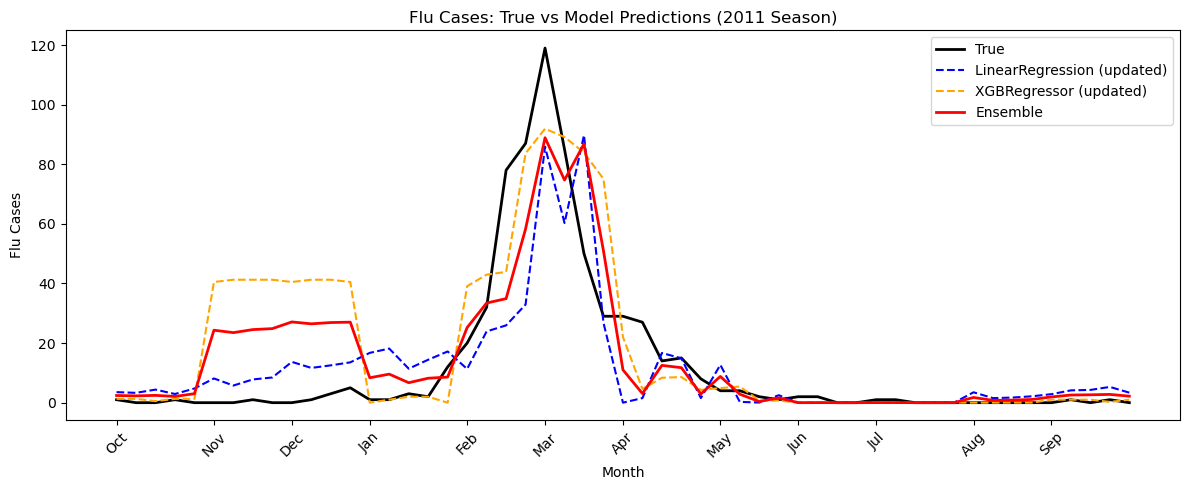

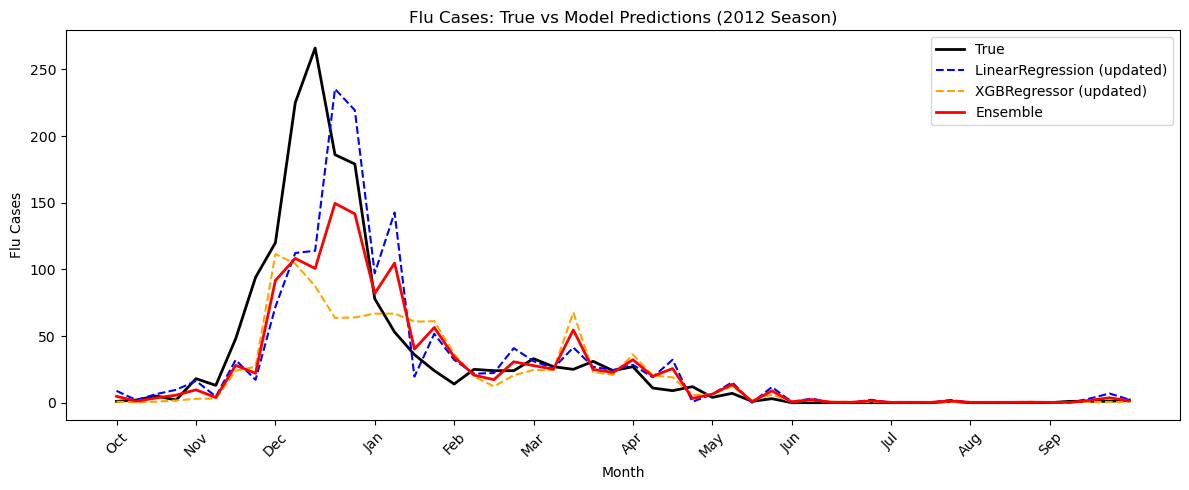

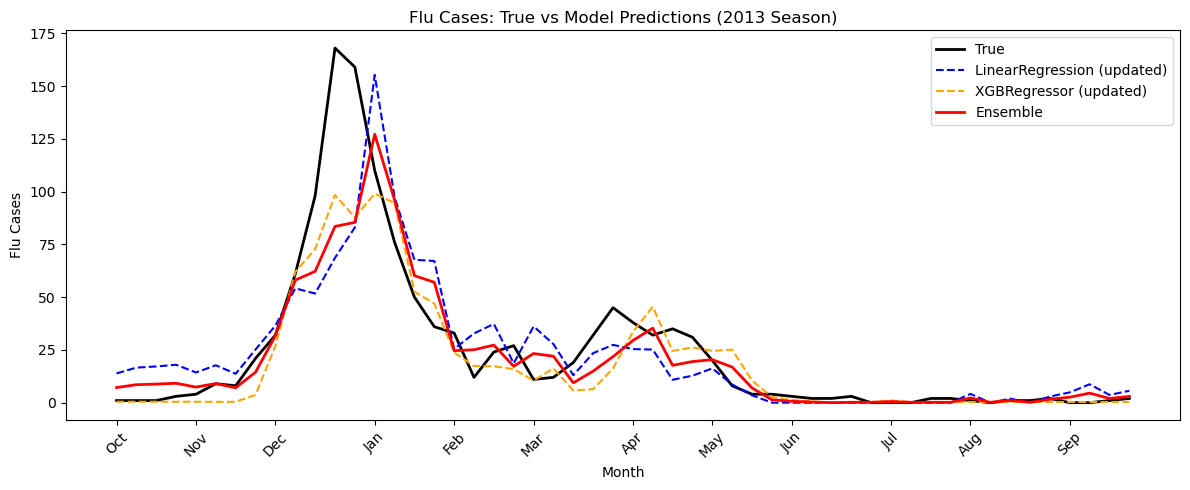

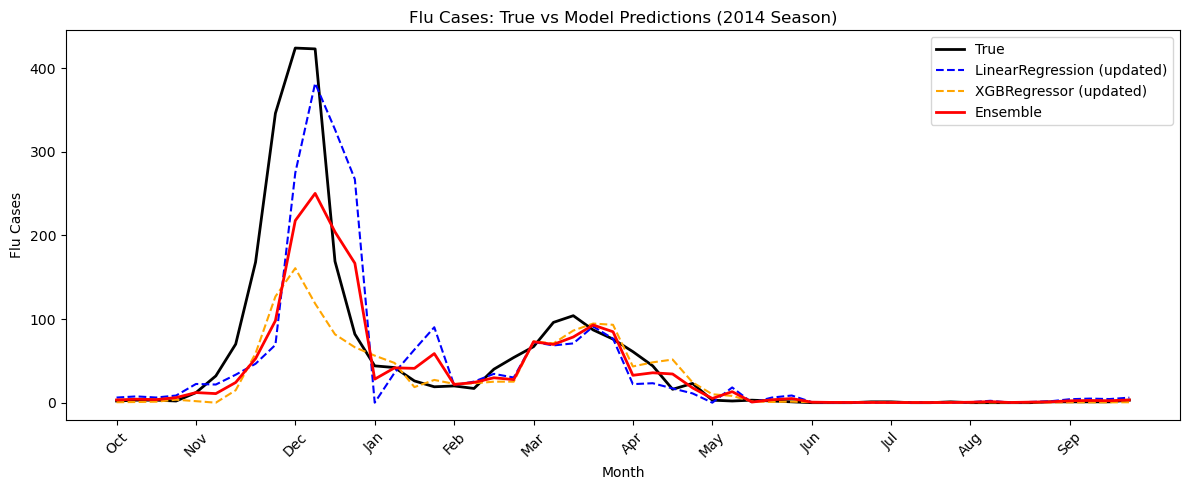

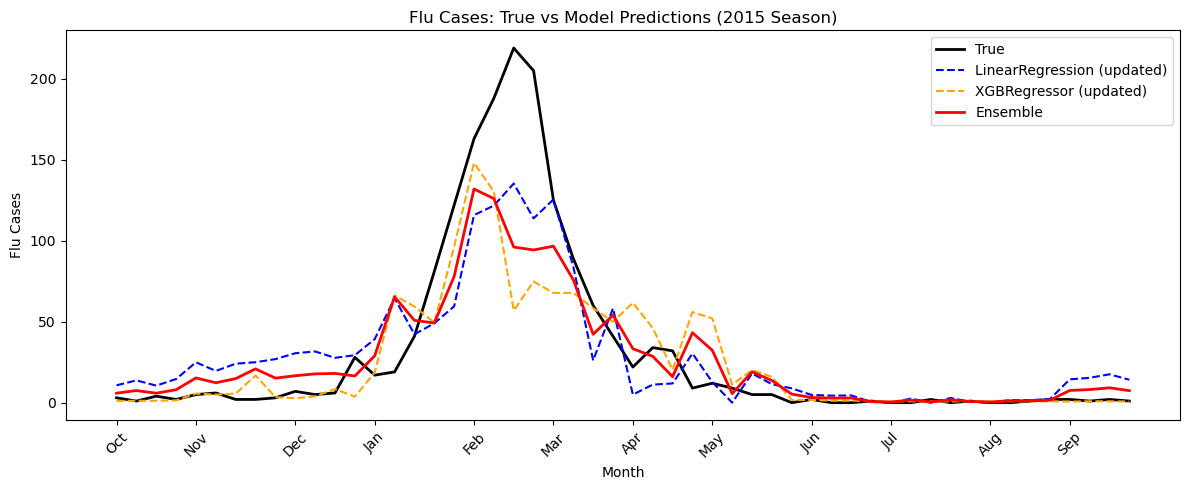

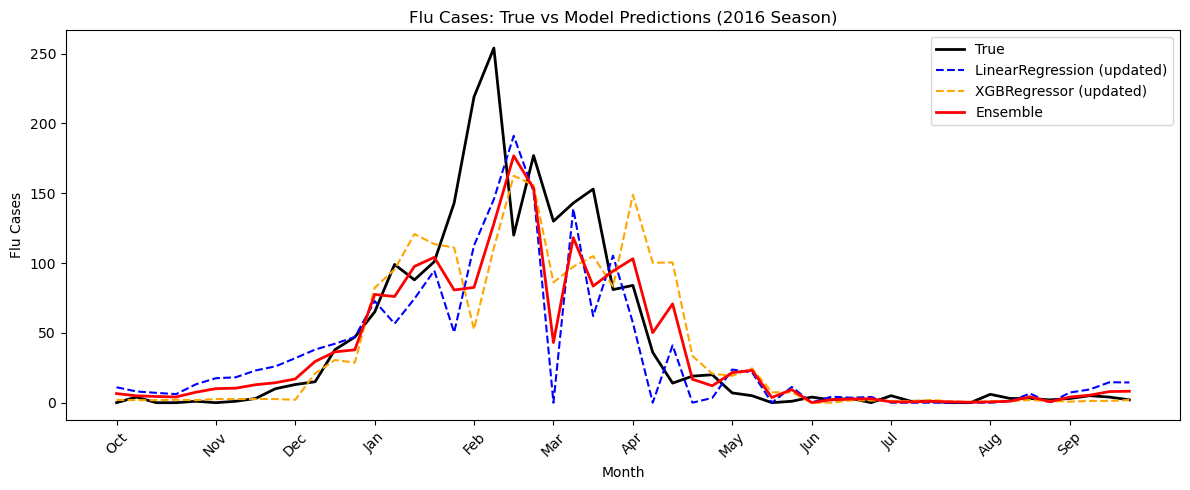

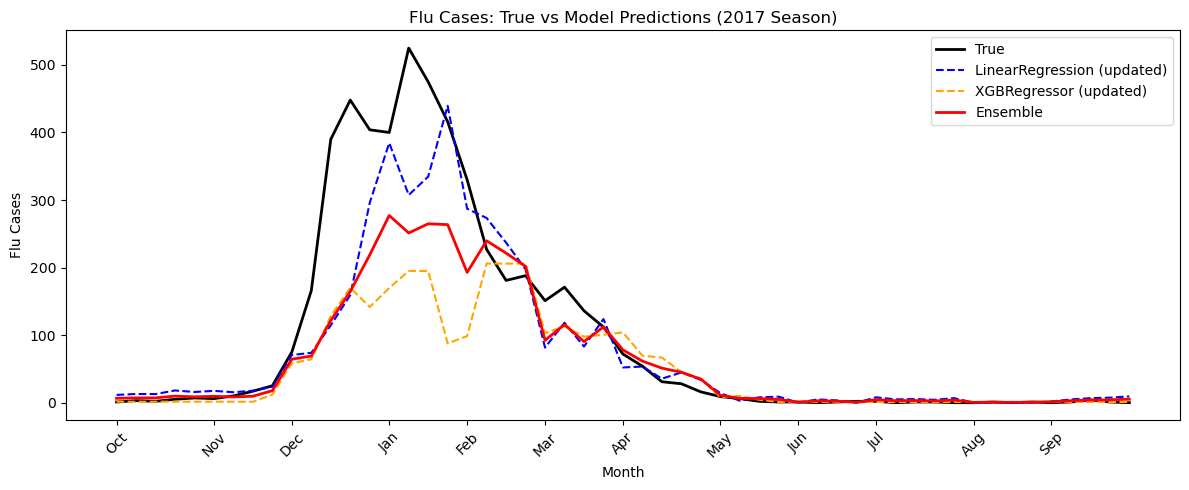

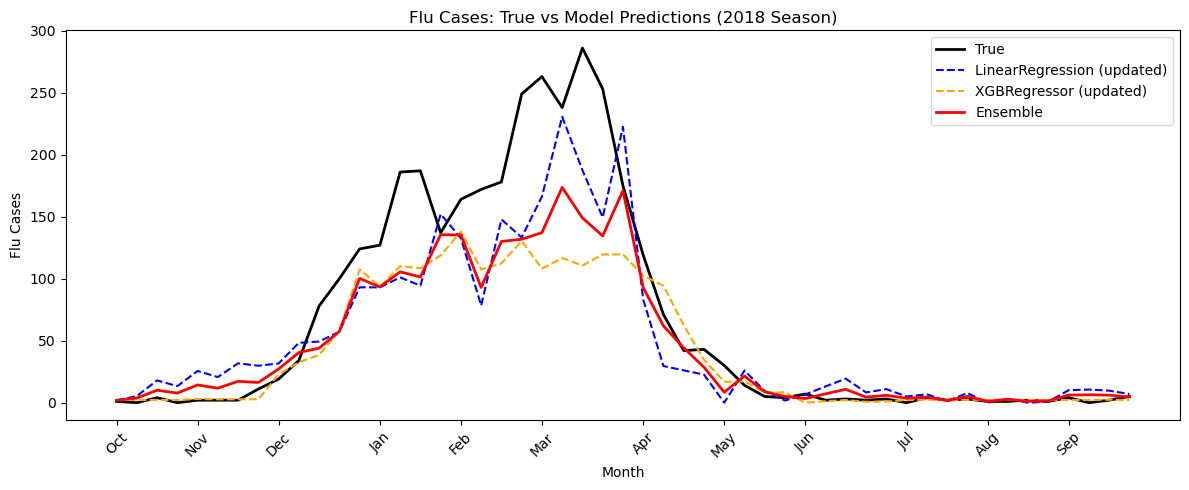

In [13]:
for yr in sorted(lr_preds_ens.keys()):
    lr_season = lr_preds_ens[yr]
    xgb_season = xgb_preds_ens[yr]
    idx = lr_season['index']
    months = lr_season['month']
    y_true = lr_season['y_true']
    y_pred_lr = lr_season['y_pred']
    y_pred_xgb = xgb_season['y_pred']
    y_pred_ensemble = ensemble_preds_ens[yr]['y_pred_ensemble'] if yr in ensemble_preds_ens else None

    plt.figure(figsize=(12,5))
    plt.plot(idx, y_true, label='True', color='black', linewidth=2, linestyle='-')
    plt.plot(idx, y_pred_lr, label='LinearRegression (updated)', linestyle='--', color='blue')
    plt.plot(idx, y_pred_xgb, label='XGBRegressor (updated)', linestyle='--', color='orange')
    if y_pred_ensemble is not None:
        plt.plot(idx, y_pred_ensemble, label='Ensemble', color='red', linewidth=2, linestyle='-')
    plt.title(f'Flu Cases: True vs Model Predictions ({yr} Season)')
    plt.xlabel('Month')
    plt.ylabel('Flu Cases')
    unique_months = []
    unique_locs = []
    for i, m in enumerate(months):
        if len(unique_months) == 0 or m != unique_months[-1]:
            unique_months.append(m)
            unique_locs.append(idx.iloc[i])
    plt.xticks(unique_locs, unique_months, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


The reported weighted RMSE of 51 is just shy of the updated LR's 47, but can be further tuned. The ensemble approach leverages the strengths of both Linear Regression (LR) and XGBoost (XGB): LR tends to provide more accurate predictions during peaks of the flu season, while XGB contributes improved accuracy before and sometimes after. However, visual inspection of the predictions indicates that all 3 predictions always underestimates the magnitude of the peak.

These findings suggest that an ensemble that functions differently when before, in, and after a season peak should be more accurate and generalizable.

## Tuned Ensemble

To build a deployable and realistic model, we must design our pre-, in-, and post-peak logic so that it does not rely on future data. The peak is triggered using the gradient of y, and remains active until values drop below a set percentile. By tuning these parameters and enforcing a single peak per season, we can accurately define intervals where the ensemble shifts its model weights dynamically.

In [14]:
# Add in_peak, pre_peak, and post_peak columns to df: Use gradient to trigger ON, percentiles to stay ON/OFF
df = df.copy()
df['in_peak'] = False
df['pre_peak'] = False
df['post_peak'] = False

for season in df['season_year'].unique():
    season_idx = df['season_year'] == season
    y_vals = df.loc[season_idx, 'y'].values
    in_peak_flags = np.zeros_like(y_vals, dtype=bool)
    pre_peak_flags = np.zeros_like(y_vals, dtype=bool)
    post_peak_flags = np.zeros_like(y_vals, dtype=bool)
    peak_on = False
    below_count = 0
    peak_triggered = False  # Only allow one peak per season

    for t in range(len(y_vals)):
        y_so_far = y_vals[:t+1]
        p90 = np.percentile(y_so_far, 90)
        p60 = np.percentile(y_so_far, 60)
        y_t = y_vals[t]
        grad = y_vals[t] - y_vals[t-1] if t > 0 else 0

        if not peak_on and not peak_triggered:
            # Use gradient to trigger ON, but require y_t >= p60 to avoid noise
            if grad > 10 and y_t >= p60:
                peak_on = True
                peak_triggered = True  # Only allow one peak per season
                in_peak_flags[t] = True
                below_count = 0
        elif peak_on:
            if y_t >= p60:
                in_peak_flags[t] = True
                below_count = 0
            else:
                below_count += 1
                if below_count < 2:
                    in_peak_flags[t] = True
                else:
                    peak_on = False
                    below_count = 0  # reset for next peak

        # Set pre-peak and post-peak flags
        if not peak_on and not peak_triggered:
            pre_peak_flags[t] = True
        elif not peak_on and peak_triggered:
            post_peak_flags[t] = True

    df.loc[season_idx, 'in_peak'] = in_peak_flags
    df.loc[season_idx, 'pre_peak'] = pre_peak_flags
    df.loc[season_idx, 'post_peak'] = post_peak_flags

Now using these flags, we will grid search different parameters for model weights, scalars, and transition widths, targeting lowest RMSE for selection. After exploring different bounds and intial points, these resulted in lowest RMSE.

In [15]:
# Function to iteratively refine ensemble2 parameter grid (fixed grid size, 10 iterations)
def iterative_ensemble2_grid_search(
    initial_params,
    grid_size=3,
    max_iter=10,
    verbose=True
):

    param_steps = {
        'pre_peak_lr': 0.05,
        'in_peak_lr': 0.05,
        'post_peak_lr': 0.025,
        'transition_width': 1,
        'xgb_boost': 0.1,
        'lr_boost': 0.1
    }
    param_bounds = {
        'pre_peak_lr': (0.0, 1.0),
        'in_peak_lr': (0.0, 1.0),
        'post_peak_lr': (0.0, 1.0),
        'transition_width': (0,5),
        'xgb_boost': (0.6, 2.0),
        'lr_boost': (0.6, 2.0)
    }
    best_params = deepcopy(initial_params)
    best_w_rmse = float('inf')
    best_results = None
    best_preds = None
    history = []
    for it in range(max_iter):
        # Build grid around current best
        grid = {}
        for k, v in best_params.items():
            step = param_steps[k]
            if isinstance(v, int):
                vals = [max(param_bounds[k][0], v-step), v, min(param_bounds[k][1], v+step)]
                vals = sorted(set(int(round(x)) for x in vals))
            else:
                vals = [max(param_bounds[k][0], v-step), v, min(param_bounds[k][1], v+step)]
                vals = sorted(set(round(x, 4) for x in vals))
            grid[k] = vals
        # Keep grid size the same as before (3^6 = 729 upper bound)
        param_names = list(grid.keys())
        grid_tuples = list(itertools.product(*[grid[k] for k in param_names]))
        if verbose:
            print(f"\nIteration {it+1}: Searching {len(grid_tuples)} parameter combinations...")
        for vals in grid_tuples:
            params = dict(zip(param_names, vals))
            ensemble2_results = []
            ensemble2_preds = {}
            for yr in lr_preds_ens.keys():
                y_true = lr_preds_ens[yr]['y_true']
                y_pred_lr = lr_preds_ens[yr]['y_pred']
                y_pred_xgb = xgb_preds_ens[yr]['y_pred']
                idx = lr_preds_ens[yr]['index']
                months = lr_preds_ens[yr]['month']
                in_peak_flags = df.loc[idx, 'in_peak'].values if 'in_peak' in df.columns else np.zeros_like(y_true, dtype=bool)
                weights_lr = np.full_like(y_true, params['pre_peak_lr'], dtype=float)
                weights_xgb = np.full_like(y_true, 1-params['pre_peak_lr'], dtype=float)
                peak_on = False
                peak_start = None
                peak_end = None
                for i in range(len(in_peak_flags)):
                    if in_peak_flags[i] and not peak_on:
                        peak_on = True
                        peak_start = i
                        # Smoothing into peak (pre-peak to in-peak)
                        for j in range(params['transition_width']):
                            k = i - j
                            if k >= 0 and k >= peak_start - params['transition_width'] + 1:
                                frac = (params['transition_width'] - j) / params['transition_width']
                                weights_lr[k] = params['pre_peak_lr'] * frac + params['in_peak_lr'] * (1 - frac)
                                weights_xgb[k] = 1 - weights_lr[k]
                    elif not in_peak_flags[i] and peak_on:
                        peak_on = False
                        peak_end = i-1
                        # Smoothing out of peak (in-peak to post-peak)
                        for j in range(params['transition_width']):
                            k = i + j
                            if k < len(weights_lr):
                                frac = (params['transition_width'] - j) / params['transition_width']
                                weights_lr[k] = params['in_peak_lr'] * frac + params['post_peak_lr'] * (1 - frac)
                                weights_xgb[k] = 1 - weights_lr[k]
                    elif in_peak_flags[i]:
                        weights_lr[i] = params['in_peak_lr']
                        weights_xgb[i] = 1 - params['in_peak_lr']
                    elif not in_peak_flags[i] and (peak_end is not None) and (i > peak_end):
                        weights_lr[i] = params['post_peak_lr']
                        weights_xgb[i] = 1 - params['post_peak_lr']
                    else:
                        weights_lr[i] = params['pre_peak_lr']
                        weights_xgb[i] = 1 - params['pre_peak_lr']
                # Boost XGB and/or LR in peak
                xgb_boost_factor = np.where(in_peak_flags, params['xgb_boost'], 1.0)
                lr_boost_factor = np.where(in_peak_flags, params['lr_boost'], 1.0)
                y_pred_xgb_boosted = y_pred_xgb * xgb_boost_factor
                y_pred_lr_boosted = y_pred_lr * lr_boost_factor
                y_pred_ensemble2 = weights_lr * y_pred_lr_boosted + weights_xgb * y_pred_xgb_boosted
                ensemble2_preds[yr] = {
                    'y_true': y_true,
                    'y_pred_ensemble2': y_pred_ensemble2,
                    'index': idx,
                    'month': months,
                    'in_peak': in_peak_flags
                }
                mse = mean_squared_error(y_true, y_pred_ensemble2)
                rmse = np.sqrt(mse)
                mae = mean_absolute_error(y_true, y_pred_ensemble2)
                r2 = r2_score(y_true, y_pred_ensemble2)
                total_cases = y_true.sum()
                rel_rmse = rmse / total_cases if total_cases else np.nan
                ensemble2_results.append({
                    'season': yr,
                    'total_cases': int(total_cases),
                    'RMSE': rmse,
                    'MAE': mae,
                    'R2': r2,
                    'RMSE % of total': rel_rmse * 100
                })
            ensemble2_perf = pd.DataFrame(ensemble2_results)
            # Use weighted RMSE for model selection
            w_rmse = np.average(ensemble2_perf['RMSE'], weights=ensemble2_perf['total_cases'])
            if w_rmse < best_w_rmse:
                best_w_rmse = w_rmse
                best_params = deepcopy(params)
                best_results = ensemble2_perf.copy()
                best_preds = deepcopy(ensemble2_preds)
        history.append({'iteration': it+1, 'best_w_rmse': best_w_rmse, 'best_params': deepcopy(best_params)})
        if verbose:
            print(f"Best params after iteration {it+1}: {best_params}")
            print(f"Weighted RMSE: {best_w_rmse:.2f}")
    return best_params, best_results, best_preds, history

In [16]:
# Run the iterative ensemble2 grid search and display results
initial_params = {'pre_peak_lr': 0.3, 'in_peak_lr': 0.8, 'post_peak_lr': 0.5, 'transition_width': 0, 'xgb_boost': 1.0, 'lr_boost': 1.2}
best_params, best_results, best_preds, history = iterative_ensemble2_grid_search(initial_params)

# Save the final model and predictions for later use
ensemble2_params = best_params
ensemble2_perf = best_results
ensemble2_preds = best_preds
ensemble2_history = history

print("\nFinal best parameters after iterative search:")
print(ensemble2_params)
print("\nPerformance summary:")
display(ensemble2_perf)

# Show search history
import pandas as pd
history_df = pd.DataFrame(ensemble2_history)
display(history_df)

# Print final weighted RMSE
if 'RMSE' in ensemble2_perf.columns and 'total_cases' in ensemble2_perf.columns:
    final_weighted_rmse = np.average(ensemble2_perf['RMSE'], weights=ensemble2_perf['total_cases'])
    print(f"Final Weighted RMSE: {final_weighted_rmse:.2f}")


Iteration 1: Searching 486 parameter combinations...
Best params after iteration 1: {'pre_peak_lr': 0.35, 'in_peak_lr': 0.75, 'post_peak_lr': 0.525, 'transition_width': 0, 'xgb_boost': 1.1, 'lr_boost': 1.3}
Weighted RMSE: 40.35

Iteration 2: Searching 486 parameter combinations...
Best params after iteration 2: {'pre_peak_lr': 0.35, 'in_peak_lr': 0.7, 'post_peak_lr': 0.525, 'transition_width': 0, 'xgb_boost': 1.2, 'lr_boost': 1.4}
Weighted RMSE: 38.93

Iteration 3: Searching 486 parameter combinations...
Best params after iteration 3: {'pre_peak_lr': 0.3, 'in_peak_lr': 0.65, 'post_peak_lr': 0.525, 'transition_width': 0, 'xgb_boost': 1.3, 'lr_boost': 1.5}
Weighted RMSE: 37.99

Iteration 4: Searching 486 parameter combinations...
Best params after iteration 4: {'pre_peak_lr': 0.3, 'in_peak_lr': 0.6, 'post_peak_lr': 0.525, 'transition_width': 0, 'xgb_boost': 1.4, 'lr_boost': 1.5}
Weighted RMSE: 37.21

Iteration 5: Searching 486 parameter combinations...
Best params after iteration 5: {'p

,season,total_cases,RMSE,MAE,R2,RMSE % of total
0,2011,643,21.808785,12.233966,0.265159,3.391724
1,2012,1657,22.799704,11.685928,0.849124,1.375963
2,2013,1247,21.910183,11.407137,0.651575,1.757032
3,2014,2593,43.457989,19.532315,0.792381,1.675973
4,2015,1587,24.645524,14.571258,0.802736,1.552963
5,2016,2135,38.357321,20.776720,0.624990,1.796596
6,2017,5106,50.299311,24.707108,0.889601,0.985102
7,2018,3362,25.758238,15.475384,0.913784,0.766158


,iteration,best_w_rmse,best_params
0,1,40.353477,"{'pre_peak_lr': 0.35, 'in_peak_lr': 0.75, 'pos..."
1,2,38.930253,"{'pre_peak_lr': 0.35, 'in_peak_lr': 0.7, 'post..."
2,3,37.994566,"{'pre_peak_lr': 0.3, 'in_peak_lr': 0.65, 'post..."
3,4,37.208692,"{'pre_peak_lr': 0.3, 'in_peak_lr': 0.6, 'post_..."
4,5,36.561070,"{'pre_peak_lr': 0.3, 'in_peak_lr': 0.55, 'post..."
5,6,36.085535,"{'pre_peak_lr': 0.3, 'in_peak_lr': 0.5, 'post_..."
6,7,35.832549,"{'pre_peak_lr': 0.3, 'in_peak_lr': 0.45, 'post..."
7,8,35.802332,"{'pre_peak_lr': 0.3, 'in_peak_lr': 0.4, 'post_..."
8,9,35.801611,"{'pre_peak_lr': 0.25, 'in_peak_lr': 0.4, 'post..."
9,10,35.801611,"{'pre_peak_lr': 0.25, 'in_peak_lr': 0.4, 'post..."


Final Weighted RMSE: 35.80


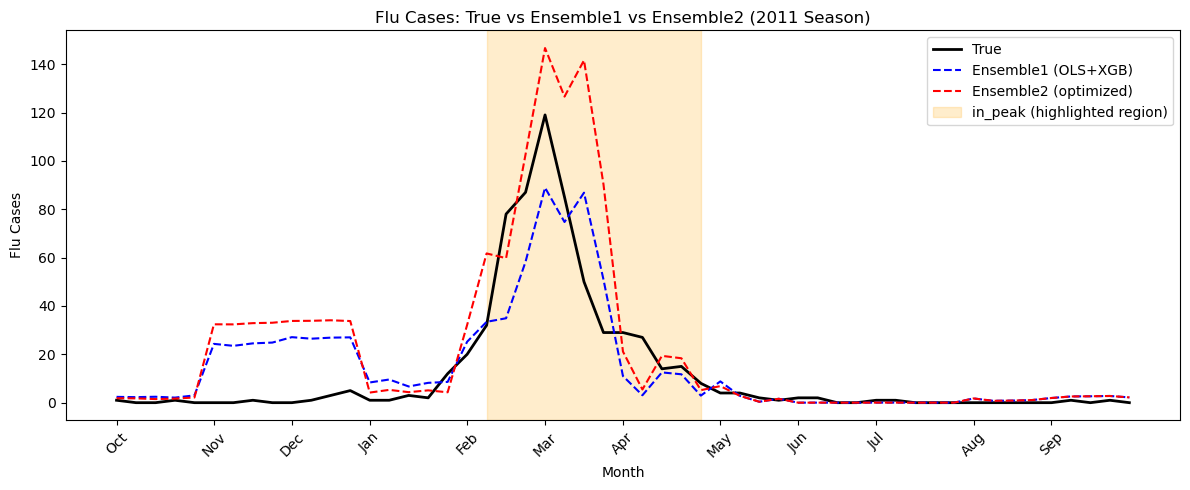

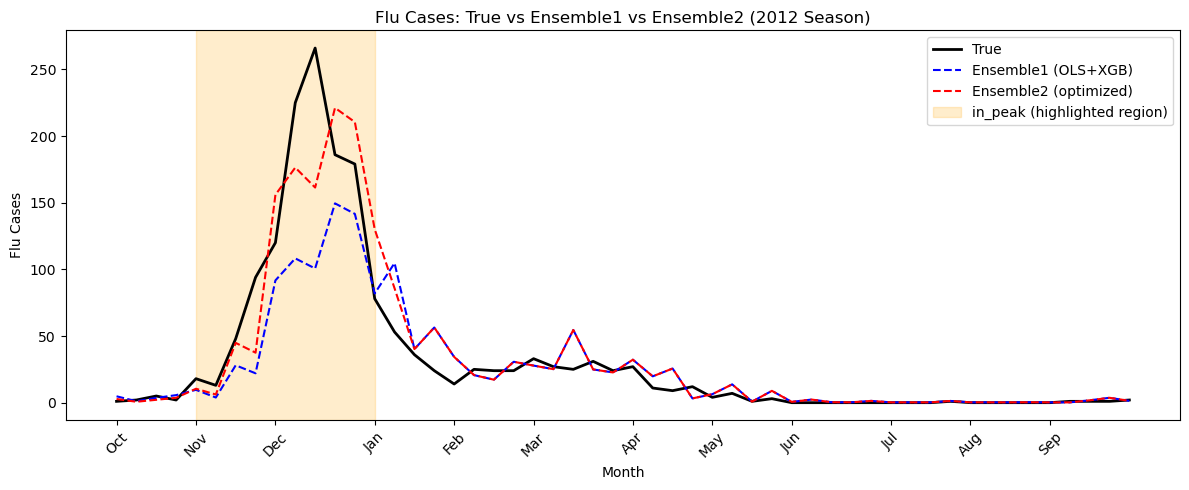

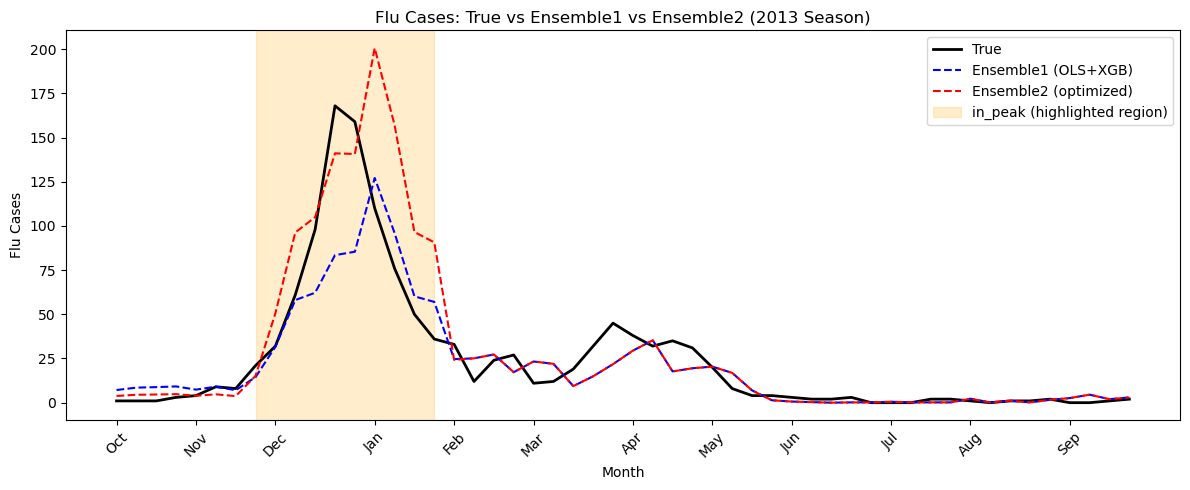

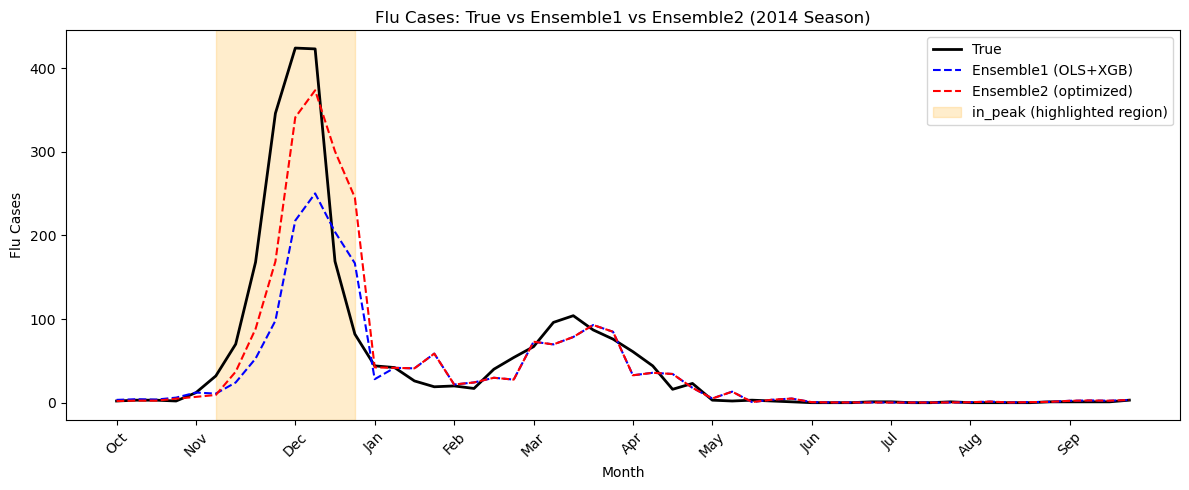

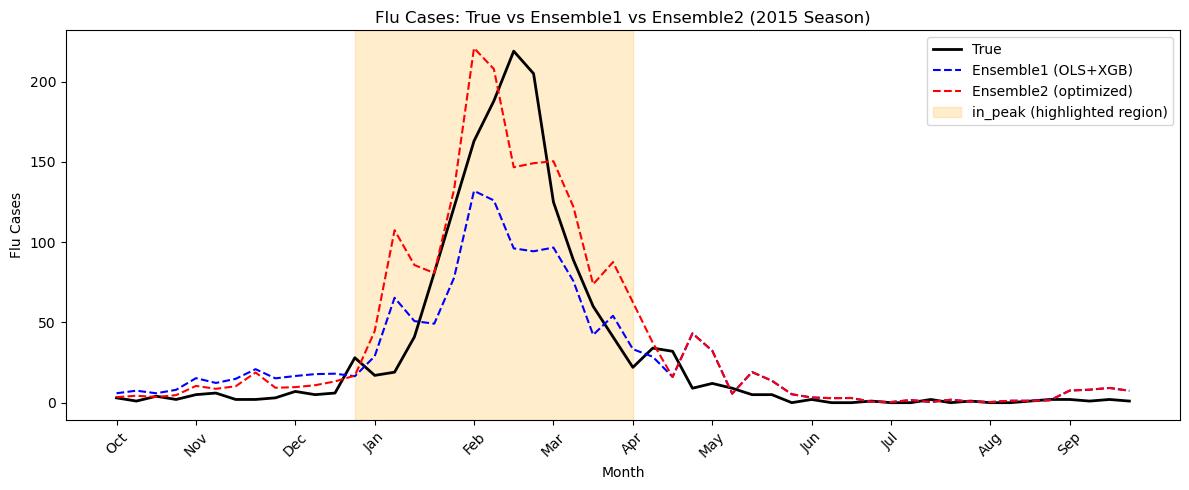

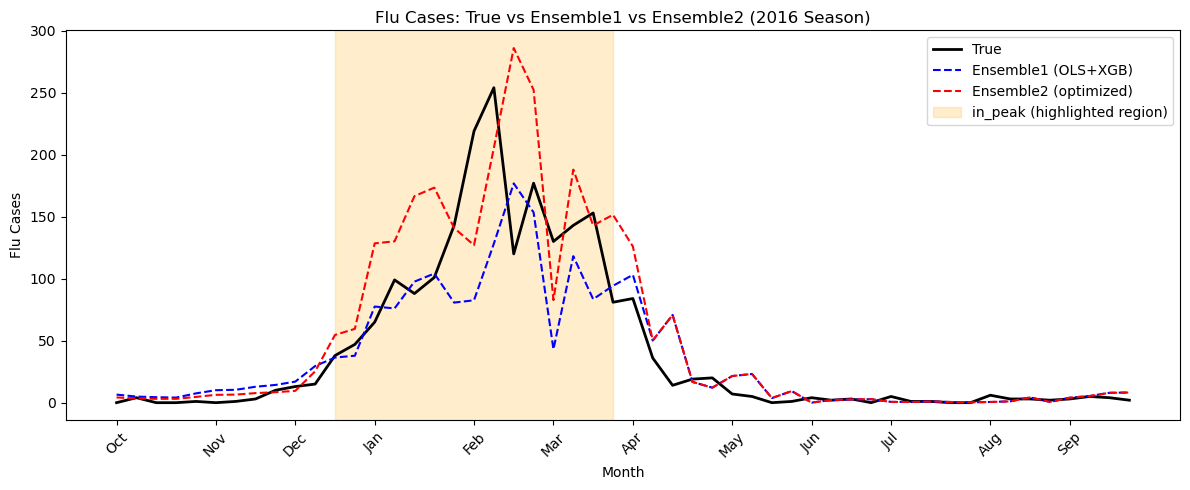

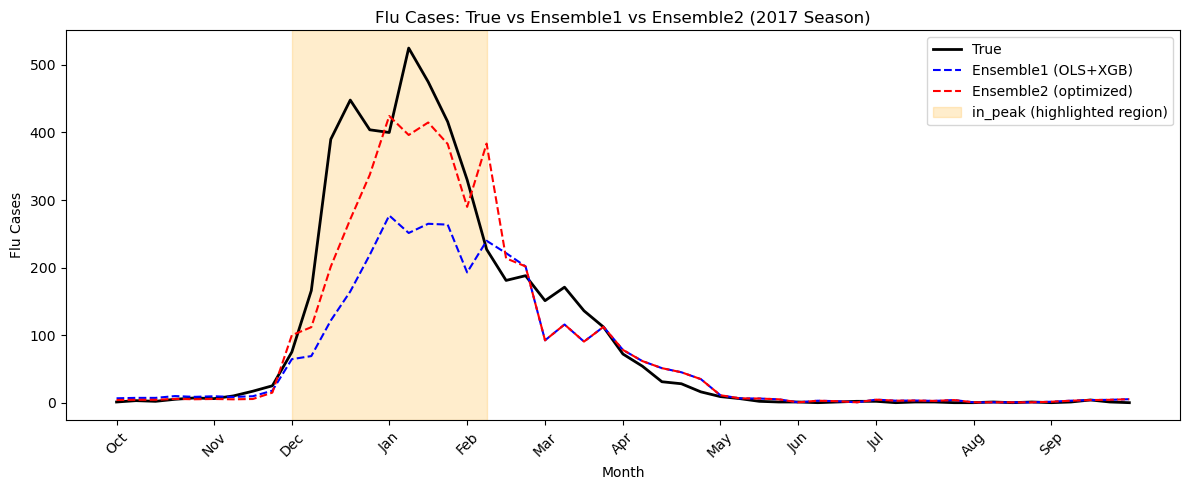

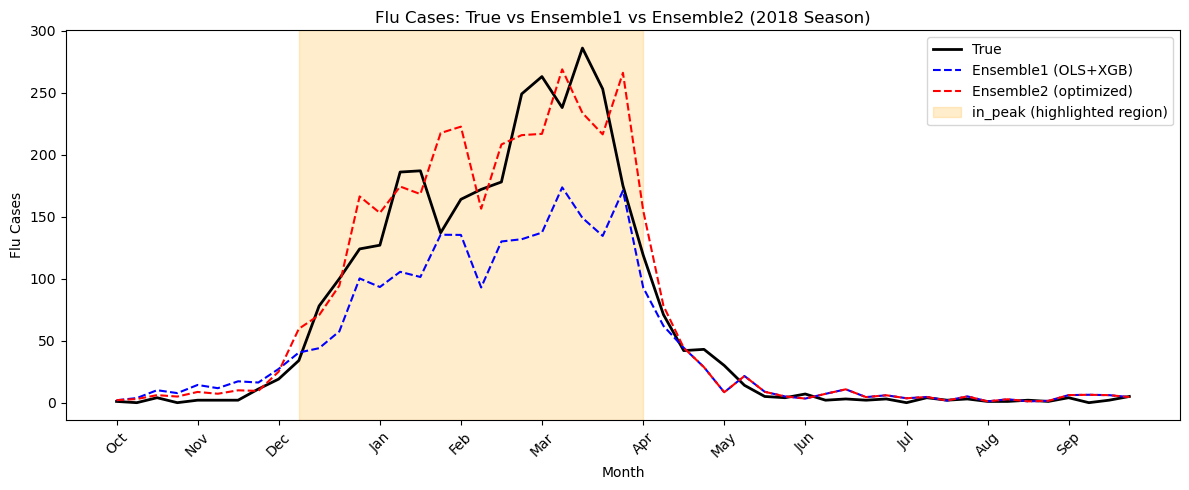

In [17]:
# Plot Ensemble2, Ensemble1, and True y, with in_peak region highlight and legend entry for in_peak
for yr in sorted(lr_preds_ens.keys()):
    idx = lr_preds_ens[yr]['index']
    months = lr_preds_ens[yr]['month']
    y_true = lr_preds_ens[yr]['y_true']
    y_pred_ens1 = ensemble_preds_ens[yr]['y_pred_ensemble'] if yr in ensemble_preds_ens else None
    y_pred_ens2 = ensemble2_preds[yr]['y_pred_ensemble2'] if yr in ensemble2_preds else None
    in_peak = ensemble2_preds[yr]['in_peak'] if yr in ensemble2_preds else np.zeros_like(y_true, dtype=bool)

    plt.figure(figsize=(12,5))
    plt.plot(idx, y_true, label='True', color='black', linewidth=2, linestyle='-')
    if y_pred_ens1 is not None:
        plt.plot(idx, y_pred_ens1, label='Ensemble1 (OLS+XGB)', linestyle='--', color='blue')
    if y_pred_ens2 is not None:
        plt.plot(idx, y_pred_ens2, label='Ensemble2 (optimized)', linestyle='--', color='red')
    # Highlight in_peak regions as filled spans
    in_peak_patch = None
    if np.any(in_peak):
        in_peak = np.array(in_peak)
        start = None
        for i in range(len(in_peak)):
            if in_peak[i] and start is None:
                start = i
            elif not in_peak[i] and start is not None:
                plt.axvspan(idx[start], idx[i-1], color='orange', alpha=0.2)
                start = None
        if start is not None:
            plt.axvspan(idx[start], idx[-1], color='orange', alpha=0.2)
        # Create a patch for the legend
        in_peak_patch = mpatches.Patch(color='orange', alpha=0.2, label='in_peak (highlighted region)')

    plt.title(f'Flu Cases: True vs Ensemble1 vs Ensemble2 ({yr} Season)')
    plt.xlabel('Month')
    plt.ylabel('Flu Cases')
    # Show each month name only once on the x-axis
    unique_months = []
    unique_locs = []
    for i, m in enumerate(months):
        if len(unique_months) == 0 or m != unique_months[-1]:
            unique_months.append(m)
            unique_locs.append(idx[i])
    plt.xticks(unique_locs, unique_months, rotation=45)
    # Add the in_peak patch to the legend if present
    handles, labels = plt.gca().get_legend_handles_labels()
    if in_peak_patch is not None:
        handles.append(in_peak_patch)
        labels.append('in_peak (highlighted region)')
    plt.legend(handles, labels)
    plt.tight_layout()
    plt.show()


For any initial parameter guesses within the bounds, our grid search tends to the displayed final parameters. This optimized ensemble biases towards XGB pre-peak, boosts each model considerably (slightly favoring XGB), and then settles at our initial 50/50 split post-peak. The forward-only transition function proved unnecessary no matter the initial guess. Plotting the results also shows consistency and accuracy of our in_peak flags, and the weighted RMSE of 35.8 is large improvement over the raw ensemble.

## Predictive Intervals for Ensemble Confidence

Now to test the confidence of this ensemble, we'll compute and display predictive intervals. We'll avoid bootstrapping, because any duplicated or reordered row/block would result in unrealistic data due to in_peak logic and lagged case predictors. Instead, we will find quantile predictions for each model, then combine them with the same parameters as ensemble 2.

In [18]:
def get_lr_quantile_preds(alpha, features, df):
    import statsmodels.api as sm
    class QuantileLinearRegressor:
        def __init__(self, quantile):
            self.quantile = quantile
            self.models = []
            self.results = []
        def fit(self, X, y):
            X_sm = sm.add_constant(X)
            model = sm.QuantReg(y, X_sm)
            res = model.fit(q=self.quantile, max_iter=20000)
            self.models.append(model)
            self.results.append(res)
            self.res_ = res
            self.X_columns_ = X_sm.columns
            return self
        def predict(self, X):
            X_sm = sm.add_constant(X)
            X_sm = X_sm.reindex(columns=self.X_columns_, fill_value=1.0)
            return self.res_.predict(X_sm)
    lrq = QuantileLinearRegressor(alpha)
    _, _, lr_preds = eval_seasonal(lrq, df, features, target='y', show_summary=False)
    return lr_preds

def get_xgb_quantile_preds(alpha, features, df):
    from xgboost import XGBRegressor
    model = XGBRegressor(
        n_estimators=100, max_depth=3, learning_rate=0.1, verbosity=0,
        objective="reg:quantileerror", quantile_alpha=alpha, random_state=13
    )
    _, _, preds = eval_seasonal(model, df, features, target='y', show_summary=False)
    return preds


In [19]:
# Combine quantile predictions from LR and XGB models in the same way as our optimized ensemble
def ensemble_quantile_preds(
    lr_lower_preds: dict,
    lr_upper_preds: dict,
    xgb_lower_preds: dict,
    xgb_upper_preds: dict,
    df: pd.DataFrame,
    params: dict
) -> dict:
    ensemble_preds = {}
    for yr in lr_lower_preds.keys():
        y_true = lr_lower_preds[yr]['y_true']
        idx = lr_lower_preds[yr]['index']
        months = lr_lower_preds[yr]['month']
        in_peak_flags = df.loc[idx, 'in_peak'].values if 'in_peak' in df.columns else np.zeros_like(y_true, dtype=bool)

        lr_lower = np.asarray(lr_lower_preds[yr]['y_pred']).flatten()
        lr_upper = np.asarray(lr_upper_preds[yr]['y_pred']).flatten()
        xgb_lower = np.asarray(xgb_lower_preds[yr]['y_pred']).flatten()
        xgb_upper = np.asarray(xgb_upper_preds[yr]['y_pred']).flatten()

        if not (len(lr_lower) == len(lr_upper) == len(xgb_lower) == len(xgb_upper) == len(idx)):
            print(f"[ERROR] Length mismatch in season {yr}: lr_lower={len(lr_lower)}, lr_upper={len(lr_upper)}, xgb_lower={len(xgb_lower)}, xgb_upper={len(xgb_upper)}, idx={len(idx)}")
            continue

        weights_lr = np.full_like(y_true, params['pre_peak_lr'], dtype=float)
        weights_xgb = np.full_like(y_true, 1 - params['pre_peak_lr'], dtype=float)

        for i in range(len(in_peak_flags)):
            if in_peak_flags[i]:
                weights_lr[i] = params['in_peak_lr']
                weights_xgb[i] = 1 - params['in_peak_lr']
            elif i > 0 and in_peak_flags[i - 1] and not in_peak_flags[i]:
                weights_lr[i] = params['post_peak_lr']
                weights_xgb[i] = 1 - params['post_peak_lr']
            else:
                weights_lr[i] = params['pre_peak_lr']
                weights_xgb[i] = 1 - params['pre_peak_lr']

        xgb_boost_factor = np.where(in_peak_flags, params['xgb_boost'], 1.0)
        lr_boost_factor = np.where(in_peak_flags, params['lr_boost'], 1.0)

        xgb_lower_boosted = xgb_lower * xgb_boost_factor
        xgb_upper_boosted = xgb_upper * xgb_boost_factor
        lr_lower_boosted = lr_lower * lr_boost_factor
        lr_upper_boosted = lr_upper * lr_boost_factor

        interval_a = weights_lr * lr_lower_boosted + weights_xgb * xgb_lower_boosted
        interval_b = weights_lr * lr_upper_boosted + weights_xgb * xgb_upper_boosted
        ensemble_lower = np.minimum(interval_a, interval_b)
        ensemble_upper = np.maximum(interval_a, interval_b)

        ensemble_preds[yr] = {
            'y_true': y_true,
            'ensemble_lower': ensemble_lower,
            'ensemble_upper': ensemble_upper,
            'index': idx,
            'month': months,
            'in_peak': in_peak_flags
        }
    return ensemble_preds

In [20]:
# Run quantile predictions for 80% and 95% intervals
quantile_levels = [0.8, 0.95]
ensemble_interval_preds = {}
for q in quantile_levels:
    lower_alpha = 1 - q
    upper_alpha = q
    # Get predictions for each model and quantile
    lr_lower_preds = get_lr_quantile_preds(lower_alpha, features_lr, df)
    lr_upper_preds = get_lr_quantile_preds(upper_alpha, features_lr, df)
    xgb_lower_preds = get_xgb_quantile_preds(lower_alpha, features_xgb, df)
    xgb_upper_preds = get_xgb_quantile_preds(upper_alpha, features_xgb, df)

    ensemble_preds = ensemble_quantile_preds(
        lr_lower_preds, lr_upper_preds, xgb_lower_preds, xgb_upper_preds, df, ensemble2_params
    )
    ensemble_interval_preds[q] = ensemble_preds

Using quantile definitions directly with matching alphas led to over-coverage. Instead, we will search for different values to shift (s) and widen (k) the raw intervals. We'll only consider weeks within the flu season, and give more importance to accuracy in later seasons, where training data is higher. The metrics optimized for here are the difference between portion of predictions within the intervals and quantile target, as well as interval width(smaller). This will empirically lead to optimized predictive intervals, while avoiding any future data leakage, again emphasizing the realism and deployability of the ensemble.

In [21]:
def optimize_interval_shift_widen(ensemble_interval_preds, s_grid, k_grid, coverage_targets=None, in_season_flag='in_season', season_weight_power=1):
    results = []
    for quantile, preds_by_season in ensemble_interval_preds.items():
        season_keys = sorted(preds_by_season.keys())
        if coverage_targets is not None and quantile in coverage_targets:
            coverage_target = coverage_targets[quantile]
        else:
            coverage_target = quantile
        for s in s_grid:
            for k in k_grid:
                all_true = []
                all_lower = []
                all_upper = []
                all_weights = []
                for i_season, yr in enumerate(season_keys):
                    preds = preds_by_season[yr]
                    lower = np.array(preds['ensemble_lower'])
                    upper = np.array(preds['ensemble_upper'])
                    truth = np.array(preds['y_true'])
                    # Only consider in_season rows
                    if in_season_flag in preds:
                        in_season_mask = np.array(preds[in_season_flag]).astype(bool)
                    else:
                        in_season_mask = np.ones_like(truth, dtype=bool)
                    interval_center = (lower + upper) / 2
                    interval_width = (upper - lower)
                    new_lower = interval_center + s - (1 + k) * interval_width / 2
                    new_upper = interval_center + s + (1 + k) * interval_width / 2
                    # Only keep in_season
                    all_true.append(truth[in_season_mask])
                    all_lower.append(new_lower[in_season_mask])
                    all_upper.append(new_upper[in_season_mask])
                    # Weight later seasons more
                    weight = (i_season + 1) ** season_weight_power
                    all_weights.append(np.full(np.sum(in_season_mask), weight))
                all_true = np.concatenate(all_true)
                all_lower = np.concatenate(all_lower)
                all_upper = np.concatenate(all_upper)
                all_weights = np.concatenate(all_weights)
                coverage = np.average((all_true >= all_lower) & (all_true <= all_upper), weights=all_weights)
                mean_width = np.average(all_upper - all_lower, weights=all_weights)
                results.append({
                    'quantile': quantile,
                    's': s,
                    'k': k,
                    'coverage': coverage,
                    'mean_width': mean_width
                })
    results_df = pd.DataFrame(results)
    # Find best s, k for each quantile (closest to coverage_target, then minimal width)
    best_params = {}
    for quantile in results_df['quantile'].unique():
        df_q = results_df[results_df['quantile'] == quantile].copy()
        if coverage_targets is not None and quantile in coverage_targets:
            coverage_target = coverage_targets[quantile]
        else:
            coverage_target = quantile
        df_q['coverage_diff'] = np.abs(df_q['coverage'] - coverage_target)
        best_row = df_q.sort_values(['coverage_diff', 'mean_width']).iloc[0]
        best_params[quantile] = {'s': best_row['s'], 'k': best_row['k'], 'coverage': best_row['coverage'], 'mean_width': best_row['mean_width']}
    return results_df, best_params

s_grid = np.linspace(-10, 10, 20)  
k_grid = np.linspace(-0.2, 0.5, 20)  
coverage_targets = {0.8: 0.8, 0.95: 0.95}
results_df, best_params = optimize_interval_shift_widen(ensemble_interval_preds, s_grid, k_grid, coverage_targets=coverage_targets, in_season_flag='in_season', season_weight_power=2)
print('Best s, k for each quantile:')
print(best_params)

Best s, k for each quantile:
{0.8: {'s': -0.526315789473685, 'k': 0.38947368421052625, 'coverage': 0.8048895601283745, 'mean_width': 62.51098632434993}, 0.95: {'s': -1.578947368421053, 'k': 0.31578947368421045, 'coverage': 0.9493109307154993, 'mean_width': 146.09088434287224}}


In [26]:
# Save altered ensemble interval predictions for 80% and 95% using best s and k
def apply_shift_widen(preds, s, k):
    altered_preds = {}
    for yr, season_preds in preds.items():
        lower = np.array(season_preds['ensemble_lower'])
        upper = np.array(season_preds['ensemble_upper'])
        interval_center = (lower + upper) / 2
        interval_width = (upper - lower)
        new_lower = interval_center + s - (1 + k) * interval_width / 2
        new_upper = interval_center + s + (1 + k) * interval_width / 2
        # clip the lower bound so it never goes below zero
        new_lower = np.clip(new_lower, a_min=0, a_max=None)
        altered_preds[yr] = season_preds.copy()
        altered_preds[yr]['ensemble_lower'] = new_lower
        altered_preds[yr]['ensemble_upper'] = new_upper
    return altered_preds

# Get best s and k for each quantile
s_80 = best_params[0.8]['s']
k_80 = best_params[0.8]['k']
s_95 = best_params[0.95]['s']
k_95 = best_params[0.95]['k']

ensemble_interval_preds_80 = apply_shift_widen(ensemble_interval_preds[0.8], s_80, k_80)
ensemble_interval_preds_95 = apply_shift_widen(ensemble_interval_preds[0.95], s_95, k_95)

In [27]:
# Table: Coverage by year and quantile (only in_season rows, using altered intervals)
coverage_rows = []
for quantile, preds_dict in zip([0.8, 0.95], [ensemble_interval_preds_80, ensemble_interval_preds_95]):
    for yr, preds in preds_dict.items():
        y_true = np.array(preds['y_true'])
        lower = np.array(preds['ensemble_lower'])
        upper = np.array(preds['ensemble_upper'])
        in_season = np.array(preds.get('in_season', np.ones_like(y_true, dtype=bool)))
        # Only in_season rows
        y_true_in = y_true[in_season]
        lower_in = lower[in_season]
        upper_in = upper[in_season]
        coverage = np.mean((y_true_in >= lower_in) & (y_true_in <= upper_in)) if len(y_true_in) > 0 else np.nan
        coverage_rows.append({'season_year': yr, f'coverage {int(quantile*100)}%': coverage})
coverage_table = pd.DataFrame(coverage_rows)
coverage_table = coverage_table.groupby('season_year').first().reset_index()
coverage_table = coverage_table.set_index('season_year')
print('Coverage by year and quantile (in_season only):')
display(coverage_table)

Coverage by year and quantile (in_season only):


,coverage 80%,coverage 95%
season_year,,
2011,0.660377,0.943396
2012,0.538462,0.923077
2013,0.519231,0.846154
2014,0.673077,0.884615
2015,0.903846,1.000000
2016,0.711538,0.865385
2017,0.867925,0.962264
2018,0.862745,1.000000


The parameters were selected to bias towards later seasons, as shown here. Each season predictions only have 30-31 points, thus variance is high, which is why it is not surprising to see a 100% coverage for 95%. The accuracy of these intervals support their generalizability. It is possible to fit more accurate intervals by using in_peak flags, amplifying or reducing uncertainty based on peaks, but this could be considered overfitting with only 8 years.

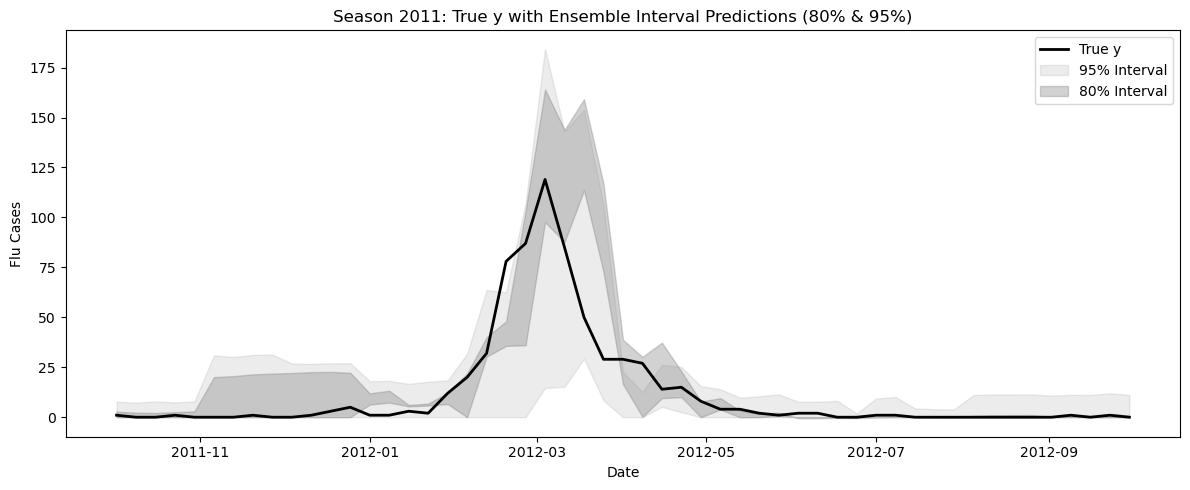

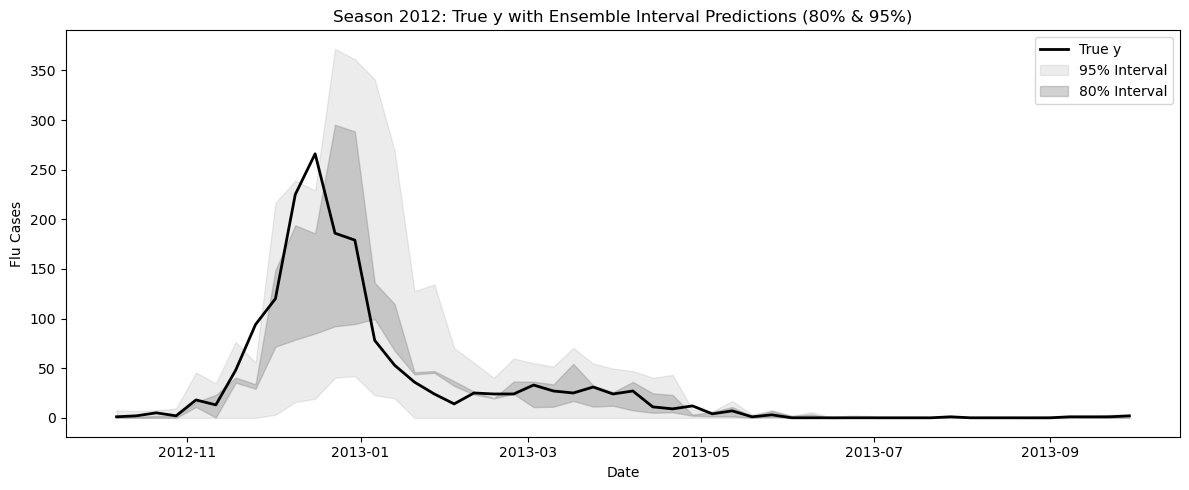

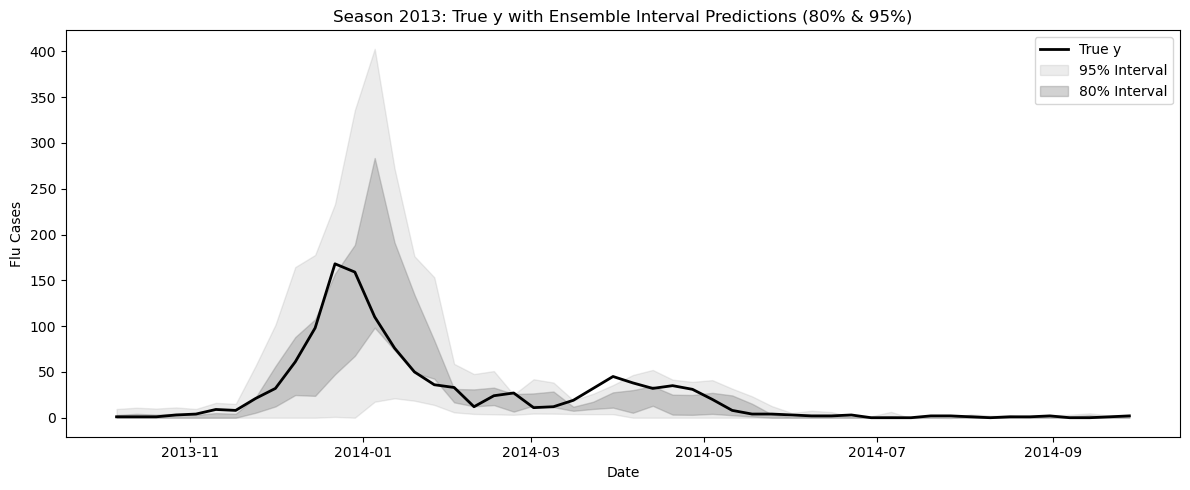

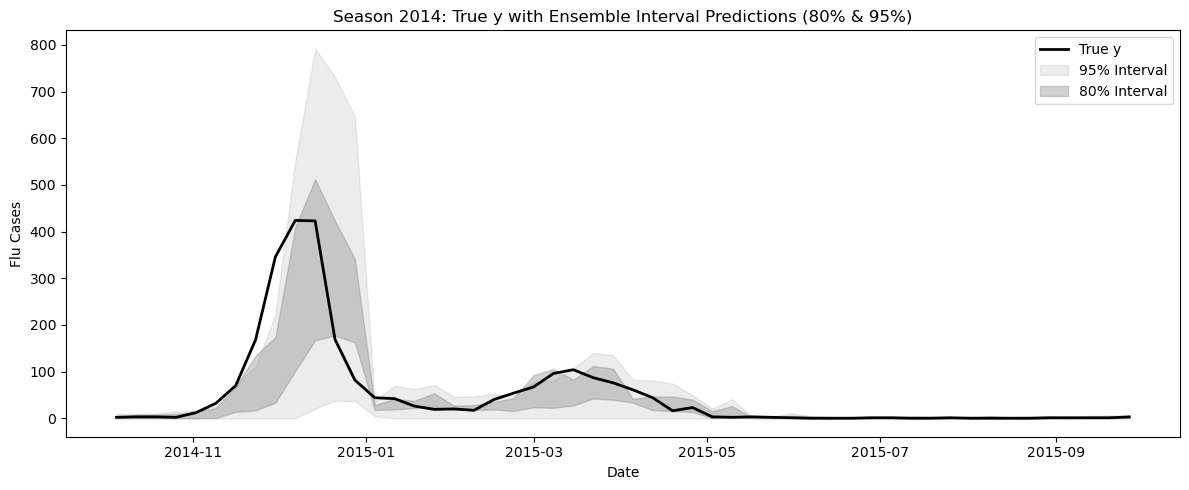

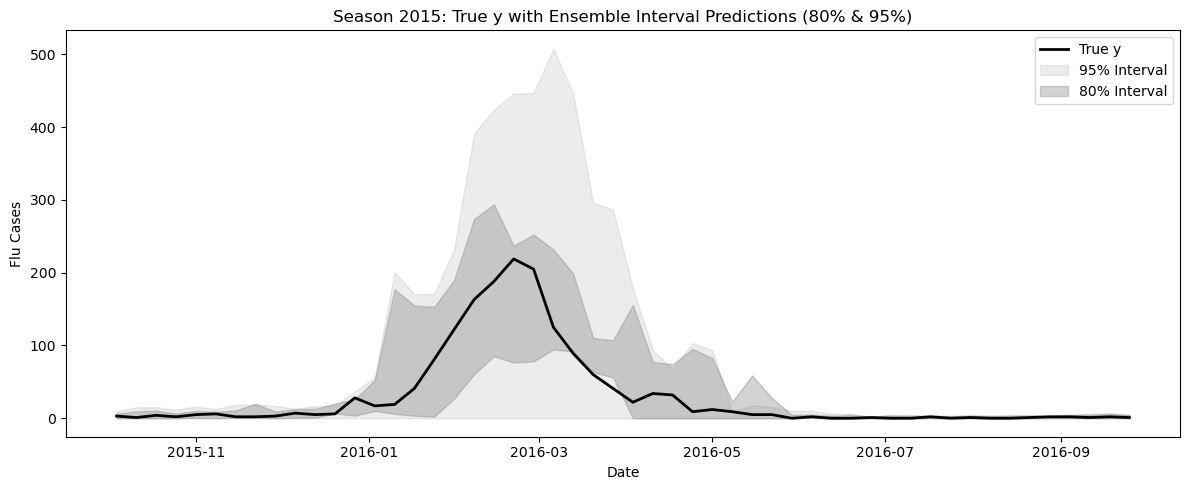

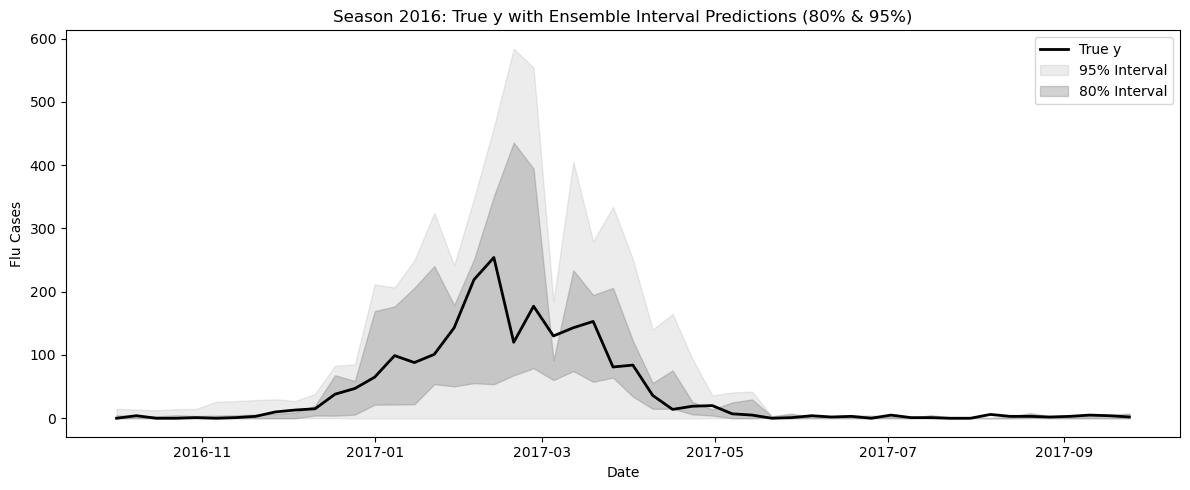

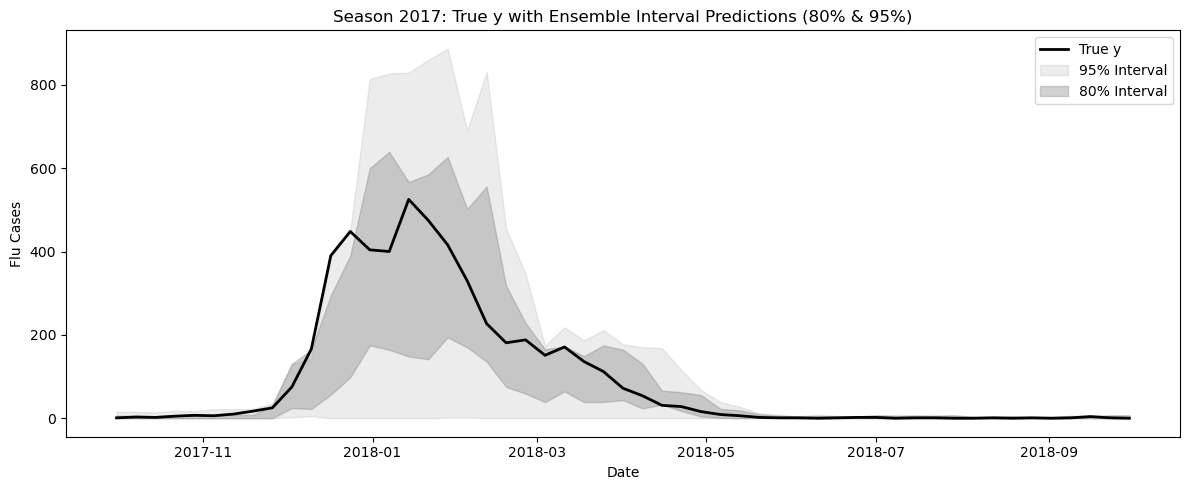

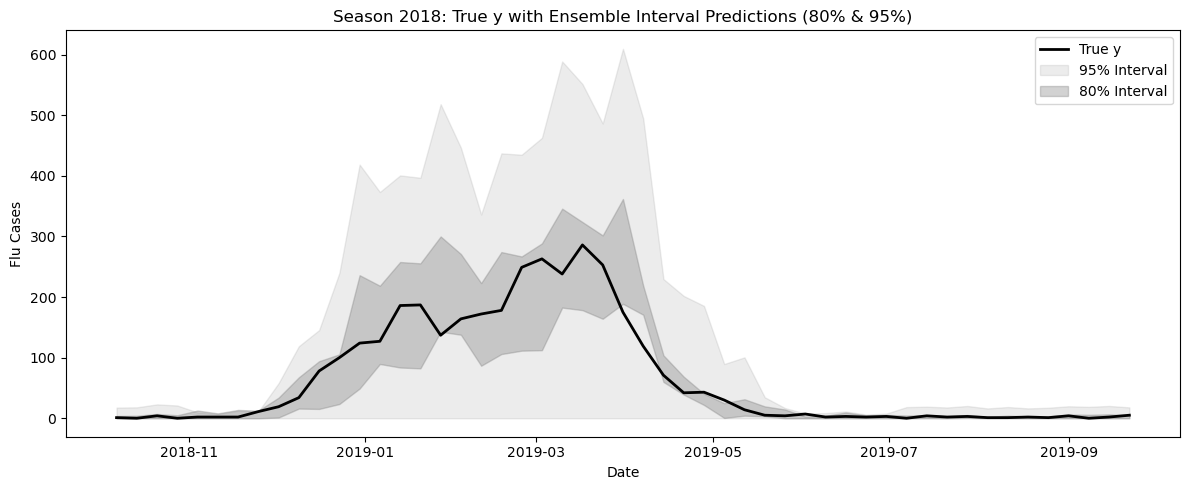

In [28]:
for yr in sorted(ensemble_interval_preds_80.keys()):
    preds_80 = ensemble_interval_preds_80[yr]
    preds_95 = ensemble_interval_preds_95.get(yr, None)
    idx = preds_80['index']
    y_true = preds_80['y_true']
    lower_80 = preds_80['ensemble_lower']
    upper_80 = preds_80['ensemble_upper']
    if preds_95:
        lower_95 = preds_95['ensemble_lower']
        upper_95 = preds_95['ensemble_upper']
    else:
        lower_95 = upper_95 = None

    plt.figure(figsize=(12,5))
    plt.plot(idx, y_true, label='True y', color='black', linewidth=2)
    if lower_95 is not None and upper_95 is not None:
        plt.fill_between(idx, lower_95, upper_95, color='gray', alpha=0.15, label='95% Interval')
    plt.fill_between(idx, lower_80, upper_80, color='gray', alpha=0.35, label='80% Interval')
    plt.title(f'Season {yr}: True y with Ensemble Interval Predictions (80% & 95%)')
    plt.xlabel('Date')
    plt.ylabel('Flu Cases')
    handles, labels = plt.gca().get_legend_handles_labels()
    new_handles = []
    new_labels = []
    for h, l in zip(handles, labels):
        if l == 'True y' or l == '80% Interval' or l == '95% Interval':
            new_handles.append(h)
            new_labels.append(l)
    plt.legend(new_handles, new_labels)
    plt.tight_layout()
    plt.show()


These results demonstrate that our ensemble’s predictive intervals are well-calibrated and increasingly accurate in later seasons, providing reliable uncertainty estimates for epidemiological forecasting. While the approach is robust and deployable, future work could further refine interval accuracy by incorporating additional data or advanced uncertainty modeling techniques. Overall, the intervals add interpretability and confidence to our forecasts, supporting informed public health responses.

## Conclusion

Through this project, we built a practical and interpretable workflow for forecasting weekly flu cases in the Chicago area. Utilizing publicly available Google Trends, weather, and vaccination data, we developed forecasts using a combination of Linear Regression and XGBoost. We prioritized realism by evaluating our models using a walk-forward, season hold-out validation method. By running ablation studies, we identified which features help and hurt each model, and tuned our models to get the most out of the available data. We implemented logic, relying only on past data, to define when peak season begins and ends. And using these flags, we optimized parameters of our enemble in order to minimize error and leverage the strengths of each individual model.

To further emphasize deployability, we then defined 80/95% prediction intervals. The intervals are empirically tuned, weighted toward later seasons when training data increases, and generated on the same data as our point forecast. Even with our small dataset of 9 seasons, our intervals are consistent and generalizable, giving public health decision-makers both point forecasts and a realistic sense of confidence.

There’s still room to grow: more seasons, external validation, or even more advanced uncertainty modeling could push accuracy further. But as it stands, this workflow can help guide real-time public health efforts in the Chicago area, as well as pose methods to build more generalizable models on larger datasets.